In [1]:
import os.path
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import keras
from keras.models import Model
from keras.layers import Dense, Input, LSTM

import sys
sys.path.insert(0, "src")
from Utils import load_processed_data, LABELS

import random
import IPython

Using TensorFlow backend.


In [2]:
def execute_layers(inputs, layers):
    """
    Computes each input to all given layers and return their outputs
    @param inputs : List of inputs to be passed through the given layer(s)
    @param layers : List of layers though which each input will be passed
    @return       : List of output generated from each input
    """
    outputs = []
    for _input in inputs:
        _output = _input
        for layer in layers:
            _output = layer(_output)
        outputs.append(_output)
    return outputs


In [3]:
max_review_length = 150
NUM_LABELS = len(LABELS)
data_train, labels_train, data_test, labels_test = load_processed_data("Processed Data 12.06.2019 00.05.csv", 
                                                                       review_length=max_review_length, 
                                                                       pad_pos="start",
                                                                       train_ratio=0.08)
print("Train data: {}, Test data: {}".format(len(labels_train), len(labels_test)))

Train data: 65, Test data: 725


In [4]:
class Host(object):
    def __init__(self, _param=None, _score=0):
        self.param = _param
        self.score = _score

    @property
    def param_str(self):
        return ",".join(map(str, self.param))
    
    @param_str.setter
    def param_str(self, value):
        print("Permission denied!")

In [12]:
class Evolver(object):
    def __init__(self, mask="111111", decay_rate=0.022, mutate_prob=0.8, log_file=None):
        self.mask = mask
        self.decay_rate = decay_rate             # 0.022
        self.decay = self.getDecay(t=0)
        self.mutate_prob = mutate_prob
        self.hosts = []
        self.scores = []
        self.host_num = 0
        self.log_dir = "Log"
        self.log_file = log_file or "Log {date}.txt".format(date=datetime.now().strftime("%d.%m.%Y %H.%M"))
        if not os.path.exists(self.log_dir):
            print("- Creating log directory {}".format(self.log_dir))
            os.mkdir(self.log_dir)
    
    def generateModels(self, num_of_models=10, param=None, file_name=None):
        self.hosts.clear()
        if param:
            if type(param) in (list, tuple):
                print("Generating model from parameters!")
                self.hosts += [Host(p, score=0) for p in param]
            else:
                print("x Invalid param type received; {}".format(type(param)))
        elif file_name:
            print("Generating model from a file!")
            self.loadParameters(file_name)
        else:
            print("Generating random models!")
            for i in range(num_of_models):
                param = np.random.randint(low=1, high=256, size=4)
                #param = [random.randint(1+i*10, 10+(i+2)*10) for i in range(4, 0, -1)]
                self.hosts.append(Host(param, 0))
        self.host_num = len(self.hosts)

    def loadParameters(self, file_name):
        def str2list(string):
            string = string.rstrip("\n")
            param, score = string.split("=")
            return (list(map(int, param.split(","))), float(score))

        with open(file_name, "r") as file:
            self.hosts.clear()
            for param in file:
                _param, _score = str2list(param)
                self.hosts.append(Host(_param, _score))
        print("Parameters loaded from {}!".format(file_name))
            
    def saveParameters(self, file_name, file_mode="w"):
        list2str = lambda array: ",".join(map(str, array))
        with open(os.path.join(self.log_dir, file_name), file_mode) as out_file:
            for host in self.hosts:
                out_file.write("{}={}\n".format(host.param_str, host.score))
        print("Parameters saved at {}!".format(file_name))
            
    def createModel(self, param, input_shape, output_size, name="Unknown"):
        input_x = Input(shape=input_shape, name="Acceleration_x")
        input_y = Input(shape=input_shape, name="Acceleration_y")
        input_z = Input(shape=input_shape, name="Acceleration_z")
        shared_layers = (LSTM(param[0],  activation="tanh", name="Shared_LSTM", dropout=0.5),
                         Dense(param[1], activation="relu", name="Shared_Dense_1"),
                         Dense(param[2], activation="relu", name="Shared_Dense_2"))
        shared_output = execute_layers(inputs=(input_x, input_y, input_z), layers=shared_layers)
        concat        = keras.layers.concatenate(shared_output,  name="Concatenate")
        dense_1       = Dense(param[3],    activation="relu",    name="Dense_1")(concat)
        main_output   = Dense(output_size, activation="softmax", name="Classification_Layer")(dense_1)
        return Model(inputs=[input_x, input_y, input_z], outputs=main_output)

    def testModel(self, model, epochs=8, batch_size=10, verbose=0):
        model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
        model.fit(x=[*data_train], y=labels_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
        scores = model.evaluate(x=[*data_test], y=labels_test, batch_size=batch_size, verbose=verbose)
        #print("Accuracy: %.2f%%" % (scores[1]*100))
        return scores[1]

    def runTest(self):
        progressPercent = lambda n: float(n)/self.host_num
        out = display(IPython.display.Pretty(" "), display_id=True)
        for i, host in enumerate(self.hosts):
            out.update(IPython.display.Pretty("@ Training progress: {:>4.1f}%".format(progressPercent(i+1)*100)))
            if host.score == 0:
                model = self.createModel(host.param, (1, max_review_length), NUM_LABELS, name="Model {}".format(i))
                fitness = self.testModel(model, epochs=5)
                keras.backend.clear_session()
                self.hosts[i].score = fitness
        self.sortFitness()
        self.saveParameters(self.log_file, "a")
        self.scores.append(self.averageScore(self.host_num))
    
    def evolve(self, t):
        evolve_num = int(self.host_num/2)
        new_hosts = []
        print("\n- Evolving the hosts")
        print("  - Removing half of the weaker hosts")
        del self.hosts[-evolve_num:]
        print("  - Crossovering top 2 hosts")
        crossover_param = self.crossover(self.hosts[0].param.copy(), self.hosts[1].param.copy(), 4)
        for param in crossover_param:
            new_hosts.append(Host(param, 0))
        print("  - Mutating remaining top hosts")
        mutation_num = evolve_num - len(crossover_param)
        self.decay = self.getDecay(t)
        for _ in range(mutation_num):
            param = random.choice(self.hosts).param.copy()
            mutated_param = self.mutate(param)
            new_hosts.append(Host(mutated_param, 0))
        print("  - Adding hosts")
        print("    {}".format(", ".join("[{}]".format(host.param_str) for host in new_hosts)))
        self.hosts += new_hosts
        new_hosts.clear()

    def sortFitness(self):
        self.hosts = sorted(self.hosts, key=lambda host: host.score, reverse=True)

    def _maskHost(self, host, mask):
        return [value for value, mask_bit in zip(host, mask) if mask_bit == "1"]

    def masking(*host_indexs):
        def decorator(func):
            @wraps(func)
            def wrapper(self, *args, **kwargs):
                mask = kwargs.get("mask", self.mask)
                if args:
                    args = list(args)
                for i in host_indexs:
                    args[i] = self._maskHost(args[i], mask)
                result = func(self, *args, **kwargs)
                return result
            return wrapper
        return decorator

    def crossover(self, paramA, paramB, max_crossover=None, mask=None):
        assert len(paramA) == len(paramB), "Host A and B are not of same length; {} and {}".format(len(paramA), len(paramB))
        HOST_LEN = len(paramA)
        max_crossover = max_crossover or HOST_LEN
        assert 0 <= max_crossover <= HOST_LEN, "Maximum cross number greater than crossable host length"

        cross_index = {random.randint(0, HOST_LEN-1) for _ in range(max_crossover)}
        cross_index_A = list(cross_index.copy())
        cross_index_B = list(cross_index.copy())
        del cross_index
        random.shuffle(cross_index_B)

        print("    {} & {}".format(paramA, paramB), end=" >> ")
        print(cross_index_A, cross_index_B, sep=" & ", end=" >> ")
        for i, j in zip(cross_index_A, cross_index_B):
            paramA[i], paramB[j] = paramB[j], paramA[i]
        print("{} & {}".format(paramA, paramB))
        return paramA, paramB

    def getDecay(self, t=0):
        e = 2.718
        return e**(-self.decay_rate*t)

    def mutate(self, param, mask=None):
        PARAM_LEN = len(param)
        print("   ", param, end=" >> ")
        mutate_prob = self.mutate_prob*self.decay
        mutate_limit = max(1, round(20*self.decay))
        for i in range(PARAM_LEN):
            if random.random() <= mutate_prob:
                rand_value = random.randint(-mutate_limit, mutate_limit)
                param[i] = max(8, param[i] + rand_value)
                del rand_value
        print(param)
        return param

    def printHosts(self):
        print("\n# All hosts")
        for i in range(self.host_num):
            print(" {:>2}) {}: {:.5f}".format(i+1, self.hosts[i].param, self.hosts[i].score), end="\t\t")
            if not (i+1)%2:
                print()
        print("- Average score: {:.5f}".format(self.scores[-1]))

    def averageScore(self, num=3):
        assert 0 < num <= self.host_num, "Given number out of range!"
        mean_score = sum(self.hosts[i].score for i in range(num))/num
        return mean_score

In [13]:
evo = Evolver(decay_rate=0.001)
evo.generateModels(20)

Generating random models!


In [14]:
G = 250
for g in range(G):
    print("# Generation", g)
    evo.runTest()
    evo.printHosts()
    if (g < G-1):
        evo.evolve(g)
    print()

# Generation 0


@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [215  57  99 247]: 0.88414		  2) [205 156 144 105]: 0.87448		
  3) [137  37  50 162]: 0.85655		  4) [ 85 251 240 102]: 0.83310		
  5) [174  51 160 191]: 0.82621		  6) [127 245  29 190]: 0.81793		
  7) [230  79 100  44]: 0.81379		  8) [ 26 237 106 171]: 0.77793		
  9) [ 66  42 116 205]: 0.76966		 10) [244  85  50 210]: 0.76000		
 11) [ 28  53 222 121]: 0.74897		 12) [122 133 131  21]: 0.72966		
 13) [  5 126 210 219]: 0.70345		 14) [134 142 177  59]: 0.69517		
 15) [ 57  56 201  72]: 0.69379		 16) [231   3 235 253]: 0.68690		
 17) [134  79  96  84]: 0.65931		 18) [ 92 235  16 156]: 0.57103		
 19) [180 125  10  32]: 0.50759		 20) [212  73 146   8]: 0.40828		
- Average score: 0.73090

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [215  57  99 247] & [205 156 144 105] >> [0, 3] & [0, 3] >> [205  57  99 105] & [215 156 144 247]
  - Mutating remaining top hosts
    [ 66  42 116 205] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [205  57  99 105]: 0.89103		  2) [127 236  27 198]: 0.88690		
  3) [215  57  99 247]: 0.88414		  4) [264  79  32 210]: 0.87586		
  5) [205 156 144 105]: 0.87448		  6) [137  37  50 162]: 0.85655		
  7) [234  46 114 260]: 0.84414		  8) [ 85 251 240 102]: 0.83310		
  9) [ 35 237  97 183]: 0.82897		 10) [174  51 160 191]: 0.82621		
 11) [127 245  29 190]: 0.81793		 12) [230  79 100  44]: 0.81379		
 13) [109 227  43 190]: 0.79862		 14) [ 26 237 106 171]: 0.77793		
 15) [ 66  42 116 205]: 0.76966		 16) [244  85  50 210]: 0.76000		
 17) [215 156 144 247]: 0.74345		 18) [ 80  42 116 197]: 0.73517		
 19) [148  45  50 171]: 0.63034		 20) [ 19 240 106 152]: 0.60414		
- Average score: 0.80262

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [205  57  99 105] & [127 236  27 198] >> [1, 3] & [1, 3] >> [205 236  99 198] & [127  57  27 105]
  - Mutating remaining top hosts
    [264  79  32 210] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [215  52  87  97]: 0.89931		
  3) [205  57  99 105]: 0.89103		  4) [127 236  27 198]: 0.88690		
  5) [215  57  99 247]: 0.88414		  6) [166  51 160 206]: 0.88000		
  7) [264  79  32 210]: 0.87586		  8) [205 156 144 105]: 0.87448		
  9) [194  67 174 174]: 0.86897		 10) [137  37  50 162]: 0.85655		
 11) [234  46 114 260]: 0.84414		 12) [147  40  50 167]: 0.83862		
 13) [ 85 251 240 102]: 0.83310		 14) [ 35 237  97 183]: 0.82897		
 15) [174  51 160 191]: 0.82621		 16) [120 236  31 205]: 0.80000		
 17) [127  39  44 158]: 0.76552		 18) [267  78  24 210]: 0.75586		
 19) [205 236  99 198]: 0.74345		 20) [127  57  27 105]: 0.57241		
- Average score: 0.83138

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [215  52  87  97] >> [0, 1, 2, 3] & [2, 3, 0, 1] >> [ 87  97 215  52] & [ 46 227 275  84]
  - Mutating remaining top hosts
    [194  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [215  52  87  97]: 0.89931		
  3) [196 157 127 119]: 0.89241		  4) [215  38  84 267]: 0.89241		
  5) [205  57  99 105]: 0.89103		  6) [ 87  97 215  52]: 0.88966		
  7) [214  67 155 182]: 0.88966		  8) [127 236  27 198]: 0.88690		
  9) [215  57  99 247]: 0.88414		 10) [166  51 160 206]: 0.88000		
 11) [264  79  32 210]: 0.87586		 12) [205 156 144 105]: 0.87448		
 13) [211  83 174 173]: 0.87310		 14) [194  67 174 174]: 0.86897		
 15) [137  37  50 162]: 0.85655		 16) [206  66  87  90]: 0.83310		
 17) [205  47  82 105]: 0.81793		 18) [176  73 174 174]: 0.74483		
 19) [139 231  11 198]: 0.72276		 20) [ 46 227 275  84]: 0.69931		
- Average score: 0.85372

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [215  52  87  97] >> [1, 3] & [1, 3] >> [275  52  46  97] & [215  84  87 227]
  - Mutating remaining top hosts
    [ 87  97 215  52] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [215  52  87  97]: 0.89931		
  3) [196 157 127 119]: 0.89241		  4) [215  38  84 267]: 0.89241		
  5) [177  65 155 204]: 0.89103		  6) [205  57  99 105]: 0.89103		
  7) [ 87  97 215  52]: 0.88966		  8) [214  67 157 180]: 0.88966		
  9) [214  67 155 182]: 0.88966		 10) [127 236  27 198]: 0.88690		
 11) [215  57  99 247]: 0.88414		 12) [166  51 160 206]: 0.88000		
 13) [215  84  87 227]: 0.87310		 14) [290  65  46 227]: 0.86483		
 15) [275  52  46  97]: 0.85241		 16) [210  60 165 191]: 0.84966		
 17) [205  65  88 103]: 0.83448		 18) [146 236  16 178]: 0.77655		
 19) [ 87  86 235  52]: 0.74207		 20) [ 67 108 204  64]: 0.71172		
- Average score: 0.85966

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [215  52  87  97] >> [0, 1, 2, 3] & [2, 1, 3, 0] >> [ 87  52  97 215] & [227  84 275  46]
  - Mutating remaining top hosts
    [177  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [215  52  87  97]: 0.89931		
  3) [196  65 137 184]: 0.89793		  4) [208  62 155 202]: 0.89517		
  5) [196 157 127 119]: 0.89241		  6) [215  38  84 267]: 0.89241		
  7) [177  65 155 204]: 0.89103		  8) [205  57  99 105]: 0.89103		
  9) [ 87  97 215  52]: 0.88966		 10) [214  67 157 180]: 0.88966		
 11) [214  67 155 182]: 0.88966		 12) [127 236  27 198]: 0.88690		
 13) [196  66  69 101]: 0.85517		 14) [180  54 136 213]: 0.84966		
 15) [205  57  92 120]: 0.82759		 16) [ 87  52  97 215]: 0.81517		
 17) [230  67 136 172]: 0.80828		 18) [227  84 275  46]: 0.80552		
 19) [197  74 142 165]: 0.76414		 20) [120 230  23 194]: 0.72000		
- Average score: 0.85814

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [215  52  87  97] >> [0, 1, 2] & [1, 2, 0] >> [ 52  87 215 227] & [ 46 275  84  97]
  - Mutating remaining top hosts
    [177  65 155

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [215  52  87  97]: 0.89931		
  3) [196  65 137 184]: 0.89793		  4) [208  62 155 202]: 0.89517		
  5) [196 157 127 119]: 0.89241		  6) [215  38  84 267]: 0.89241		
  7) [177  65 155 204]: 0.89103		  8) [205  57  99 105]: 0.89103		
  9) [ 87  97 215  52]: 0.88966		 10) [214  67 157 180]: 0.88966		
 11) [166  64 162 211]: 0.86621		 12) [289 104  46 215]: 0.86207		
 13) [188  53 148 185]: 0.85517		 14) [ 52  87 215 227]: 0.83448		
 15) [170  80 166 204]: 0.76828		 16) [219  38  90 249]: 0.76138		
 17) [214 151 133 123]: 0.75448		 18) [ 46 275  84  97]: 0.68966		
 19) [ 76 100 215  42]: 0.64276		 20) [ 99  97 230  45]: 0.62207		
- Average score: 0.82986

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [215  52  87  97] >> [1, 2] & [1, 2] >> [275  52  87 227] & [215  84  46  97]
  - Mutating remaining top hosts
    [205  57  99 105] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [215  52  87  97]: 0.89931		
  3) [196  65 137 184]: 0.89793		  4) [208  62 155 202]: 0.89517		
  5) [196 157 127 119]: 0.89241		  6) [215  38  84 267]: 0.89241		
  7) [177  65 155 204]: 0.89103		  8) [205  57  99 105]: 0.89103		
  9) [ 87  97 215  52]: 0.88966		 10) [214  67 157 180]: 0.88966		
 11) [222  42 174 202]: 0.88414		 12) [216  26  65 267]: 0.87448		
 13) [103  97 227  70]: 0.86621		 14) [208  57 116 125]: 0.86069		
 15) [159  74 140 191]: 0.85655		 16) [172  50 173 209]: 0.81793		
 17) [181  51 120 204]: 0.77379		 18) [215  84  46  97]: 0.75310		
 19) [275  52  87 227]: 0.70345		 20) [ 87  93 195  33]: 0.59586		
- Average score: 0.84634

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [215  52  87  97] >> [1, 2, 3] & [3, 2, 1] >> [275  97  87  52] & [215 227  46  84]
  - Mutating remaining top hosts
    [275  84  46

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [275  97  87  52]: 0.90207		
  3) [215  52  87  97]: 0.89931		  4) [196  65 137 184]: 0.89793		
  5) [208  62 155 202]: 0.89517		  6) [196 157 127 119]: 0.89241		
  7) [215  38  84 267]: 0.89241		  8) [198  47 140 167]: 0.89241		
  9) [177  65 155 204]: 0.89103		 10) [205  57  99 105]: 0.89103		
 11) [ 87  97 215  52]: 0.88966		 12) [214  67 157 180]: 0.88966		
 13) [178  70 139 186]: 0.88690		 14) [201  42 141 186]: 0.85931		
 15) [205  74  89 105]: 0.85655		 16) [218  43  99 105]: 0.84276		
 17) [230  67  99  96]: 0.84138		 18) [282  92  48 239]: 0.82621		
 19) [215 227  46  84]: 0.81931		 20) [106 115 204  52]: 0.65517		
- Average score: 0.86614

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [275  97  87  52] >> [0, 1, 2] & [1, 0, 2] >> [ 97 275  87 227] & [ 84 275  46  52]
  - Mutating remaining top hosts
    [208  62 155

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [275  84  46 227]: 0.90207		  2) [275  97  87  52]: 0.90207		
  3) [215  52  87  97]: 0.89931		  4) [196  65 137 184]: 0.89793		
  5) [208  62 155 202]: 0.89517		  6) [201  64  99  97]: 0.89379		
  7) [196 157 127 119]: 0.89241		  8) [215  38  84 267]: 0.89241		
  9) [198  47 140 167]: 0.89241		 10) [177  65 155 204]: 0.89103		
 11) [205  57  99 105]: 0.89103		 12) [198 147 141 109]: 0.88276		
 13) [203  57  91 115]: 0.87172		 14) [224  70  83 108]: 0.84690		
 15) [191  81 145 188]: 0.83034		 16) [198 173 114 128]: 0.80414		
 17) [219  73 137 202]: 0.78897		 18) [ 97 275  87 227]: 0.73517		
 19) [275  79 100  38]: 0.68276		 20) [ 84 275  46  52]: 0.64414		
- Average score: 0.84683

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [275  84  46 227] & [275  97  87  52] >> [2, 3] & [3, 2] >> [275  84  52  87] & [275  97 227  46]
  - Mutating remaining top hosts
    [208  62 155 202] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [215  70  74 113]: 0.90345		  2) [275  84  46 227]: 0.90207		
  3) [275  97  87  52]: 0.90207		  4) [215  52  87  97]: 0.89931		
  5) [196  65 137 184]: 0.89793		  6) [208  62 155 202]: 0.89517		
  7) [201  64  99  97]: 0.89379		  8) [196 157 127 119]: 0.89241		
  9) [215  38  84 267]: 0.89241		 10) [198  47 140 167]: 0.89241		
 11) [177  65 155 204]: 0.89103		 12) [275  84  52  87]: 0.86621		
 13) [181  79 155 187]: 0.85931		 14) [213  80 155 202]: 0.84414		
 15) [275  97 227  46]: 0.83172		 16) [212  58 146 183]: 0.80414		
 17) [194  62 155 187]: 0.80138		 18) [199  50  87  88]: 0.78345		
 19) [235  29  73 262]: 0.78207		 20) [158  74 162 197]: 0.76552		
- Average score: 0.86000

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [215  70  74 113] & [275  84  46 227] >> [0, 1, 2] & [2, 0, 1] >> [ 46 275  84 113] & [ 70  74 215 227]
  - Mutating remaining top hosts
    [196  65 137

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [215  70  74 113]: 0.90345		  2) [275  84  46 227]: 0.90207		
  3) [275  97  87  52]: 0.90207		  4) [215  52  87  97]: 0.89931		
  5) [196  65 137 184]: 0.89793		  6) [208  62 155 202]: 0.89517		
  7) [201  64  99  97]: 0.89379		  8) [196 157 127 119]: 0.89241		
  9) [215  38  84 267]: 0.89241		 10) [198  47 140 167]: 0.89241		
 11) [198  47 130 169]: 0.89103		 12) [257 114  76  52]: 0.88552		
 13) [275  81  32 227]: 0.88414		 14) [188  47 151 177]: 0.84828		
 15) [ 70  74 215 227]: 0.84000		 16) [216  30 140 170]: 0.83586		
 17) [186  74 138 203]: 0.83034		 18) [196 151 134 134]: 0.79034		
 19) [198  50 111 103]: 0.76552		 20) [ 46 275  84 113]: 0.73931		
- Average score: 0.86407

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [215  70  74 113] & [275  84  46 227] >> [1, 2] & [1, 2] >> [215  84  46 113] & [275  70  74 227]
  - Mutating remaining top hosts
    [275  84  46 227] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [215  70  74 113]: 0.90345		  2) [186  62 116 101]: 0.90207		
  3) [275  84  46 227]: 0.90207		  4) [275  97  87  52]: 0.90207		
  5) [215  52  87  97]: 0.89931		  6) [196  65 137 184]: 0.89793		
  7) [208  62 155 202]: 0.89517		  8) [201  64  99  97]: 0.89379		
  9) [196 157 127 119]: 0.89241		 10) [215  38  84 267]: 0.89241		
 11) [208  66  74 113]: 0.89241		 12) [198  47 140 167]: 0.89241		
 13) [275  70  74 227]: 0.88690		 14) [234  40  82  97]: 0.88000		
 15) [275  84  45 224]: 0.88000		 16) [275  81  35 215]: 0.87724		
 17) [217  38  73 248]: 0.87034		 18) [199  52 101  95]: 0.84276		
 19) [288  65  26 209]: 0.83586		 20) [215  84  46 113]: 0.73793		
- Average score: 0.87883

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [215  70  74 113] & [186  62 116 101] >> [0, 2] & [0, 2] >> [186  70 116 113] & [215  62  74 101]
  - Mutating remaining top hosts
    [201  64  99  97] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [275  84  46 227]: 0.90207		
  5) [275  97  87  52]: 0.90207		  6) [215  52  87  97]: 0.89931		
  7) [196  65 137 184]: 0.89793		  8) [208  62 155 202]: 0.89517		
  9) [201  64  99  97]: 0.89379		 10) [196 157 127 119]: 0.89241		
 11) [215  38  84 267]: 0.89241		 12) [182  61 132  96]: 0.86897		
 13) [295  93  90  55]: 0.85103		 14) [199  62 136 220]: 0.83724		
 15) [190  55 116  94]: 0.83172		 16) [215  62  74 101]: 0.81379		
 17) [190  64 103 107]: 0.78069		 18) [275  97 106  66]: 0.75310		
 19) [194  75  86 111]: 0.72690		 20) [186  70 116 113]: 0.72276		
- Average score: 0.85407

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 2, 3] & [3, 0, 2] >> [113  41 215  74] & [ 72  70 275 229]
  - Mutating remaining top hosts
    [275  97  87

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [275  84  46 227]: 0.90207		
  5) [275  97  87  52]: 0.90207		  6) [215  52  87  97]: 0.89931		
  7) [196  65 137 184]: 0.89793		  8) [208  62 155 202]: 0.89517		
  9) [201  64  99  97]: 0.89379		 10) [196 157 127 119]: 0.89241		
 11) [197  65 148 220]: 0.88828		 12) [175  45 116  88]: 0.88414		
 13) [215  70  87 133]: 0.86483		 14) [226  70  67 113]: 0.86345		
 15) [172  44 110 101]: 0.83724		 16) [216  77 137 170]: 0.83724		
 17) [ 72  70 275 229]: 0.82759		 18) [277 104  81  70]: 0.81517		
 19) [113  41 215  74]: 0.80828		 20) [215  70  87 118]: 0.72414		
- Average score: 0.86766

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [1, 2, 3] >> [229  70  74 113] & [215  41  72 275]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [275  84  46 227]: 0.90207		
  5) [275  97  87  52]: 0.90207		  6) [215  52  87  97]: 0.89931		
  7) [196  65 137 184]: 0.89793		  8) [208  62 155 202]: 0.89517		
  9) [229  70  74 113]: 0.89379		 10) [201  64  99  97]: 0.89379		
 11) [196 157 127 119]: 0.89241		 12) [197  72 137 184]: 0.88828		
 13) [198  77  72 102]: 0.87034		 14) [205  75 137 194]: 0.86207		
 15) [219  85  64 130]: 0.85517		 16) [292  90  62 219]: 0.83310		
 17) [229  41  75 278]: 0.77379		 18) [259 104  91  34]: 0.76552		
 19) [215  41  72 275]: 0.71034		 20) [286  66  46 227]: 0.66069		
- Average score: 0.85579

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 3] & [1, 0, 3] >> [ 70 215  72 113] & [ 41 229  74 275]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [215  52  87  97]: 0.89931		  8) [196  65 137 184]: 0.89793		
  9) [208  62 155 202]: 0.89517		 10) [229  70  74 113]: 0.89379		
 11) [201  64  99  97]: 0.89379		 12) [213  73  74 100]: 0.86069		
 13) [235  84  88 106]: 0.84690		 14) [222  49 155 188]: 0.82621		
 15) [ 41 229  74 275]: 0.80552		 16) [276 117 100  52]: 0.78207		
 17) [268  97  80  49]: 0.73241		 18) [291  79  87  57]: 0.73241		
 19) [188  49 146 196]: 0.65655		 20) [ 70 215  72 113]: 0.60138		
- Average score: 0.83752

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 2, 3] & [2, 3, 0] >> [ 74  41 113 215] & [275  70 229  72]
  - Mutating remaining top hosts
    [186  62 116

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [215  52  87  97]: 0.89931		  8) [196  65 137 184]: 0.89793		
  9) [202  74 169 202]: 0.89793		 10) [208  62 155 202]: 0.89517		
 11) [229  70  74 113]: 0.89379		 12) [206  67 135  86]: 0.87034		
 13) [175  77 131 121]: 0.86621		 14) [ 74  41 113 215]: 0.86483		
 15) [264 101 101  47]: 0.83724		 16) [225  51  74 113]: 0.81931		
 17) [275  70 229  72]: 0.81655		 18) [228  70  74 104]: 0.81655		
 19) [208  81 170 202]: 0.81241		 20) [274  75  27 225]: 0.79034		
- Average score: 0.87021

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [1, 3, 2] >> [229  70 113  74] & [215  41 275  72]
  - Mutating remaining top hosts
    [215  70  74

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [215  52  87  97]: 0.89931		  8) [196  65 137 184]: 0.89793		
  9) [202  74 169 202]: 0.89793		 10) [208  62 155 202]: 0.89517		
 11) [269 103  61 224]: 0.87034		 12) [275 111  95  51]: 0.86069		
 13) [199  54 138 215]: 0.84828		 14) [266  91 103  32]: 0.84276		
 15) [203  48 107  97]: 0.79724		 16) [229  70 113  74]: 0.79172		
 17) [225  34  71 275]: 0.76276		 18) [215  41 275  72]: 0.75862		
 19) [230  64  69 114]: 0.71310		 20) [205  58  87  77]: 0.70069		
- Average score: 0.84814

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 2, 3] & [0, 1, 2, 3] >> [215  70  74 113] & [229  41  72 275]
  - Mutating remaining top hosts
    [202  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [215  52  87  97]: 0.89931		  8) [202  74 189 202]: 0.89793		
  9) [196  65 137 184]: 0.89793		 10) [202  74 169 202]: 0.89793		
 11) [275 104  72  52]: 0.89655		 12) [208  62 155 202]: 0.89517		
 13) [229  41  72 275]: 0.88138		 14) [269  97  30 232]: 0.87310		
 15) [227  33  60 258]: 0.87172		 16) [204  59 135  93]: 0.85793		
 17) [215  41  97  95]: 0.84000		 18) [177  70 137 186]: 0.82207		
 19) [215  70  74 113]: 0.76414		 20) [274  79  89  38]: 0.75034		
- Average score: 0.87359

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [2, 3] & [2, 3] >> [229  41  74 113] & [215  70  72 275]
  - Mutating remaining top hosts
    [275  97  87  52] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [215  52  87  97]: 0.89931		  8) [202  74 189 202]: 0.89793		
  9) [196  65 137 184]: 0.89793		 10) [202  74 169 202]: 0.89793		
 11) [206  50  87 117]: 0.89517		 12) [171  61 106 121]: 0.88276		
 13) [229  41  74 113]: 0.87172		 14) [207  63  80  97]: 0.85379		
 15) [203  57 155 192]: 0.81655		 16) [186  57 116 106]: 0.81103		
 17) [258  79  81  45]: 0.79586		 18) [213  64  97 101]: 0.79310		
 19) [249  33  72 280]: 0.77931		 20) [215  70  72 275]: 0.74759		
- Average score: 0.86331

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 2] & [0, 2, 1] >> [215  74  70 275] & [229  72  41 113]
  - Mutating remaining top hosts
    [215  52  87

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [202  74 169 202]: 0.89793		 12) [215  74  70 275]: 0.89517		
 13) [202  74 169 201]: 0.86483		 14) [186  56 119  90]: 0.84138		
 15) [229  72  41 113]: 0.80138		 16) [198  72  79 112]: 0.79448		
 17) [232  47  87  97]: 0.76138		 18) [191  94 169 187]: 0.73103		
 19) [215  69  55 113]: 0.72552		 20) [227  33  60 268]: 0.72000		
- Average score: 0.85276

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2] & [1, 2] >> [229  70  74 275] & [215  41  72 113]
  - Mutating remaining top hosts
    [215  70  74 113] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [277 101  87  64]: 0.88690		 12) [215  90  91 106]: 0.87034		
 13) [263  85  78  43]: 0.86483		 14) [229  70  74 275]: 0.85103		
 15) [210  65 146 171]: 0.84414		 16) [215  41  72 113]: 0.82897		
 17) [226  51  62 131]: 0.80552		 18) [225  54  66 113]: 0.80276		
 19) [196  51 138 174]: 0.79724		 20) [177  52 104  83]: 0.72138		
- Average score: 0.86476

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 3] & [0, 3, 1] >> [215 113  72  70] & [229 275  74  41]
  - Mutating remaining top hosts
    [186  62 116

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [210  79 189 202]: 0.89241		 12) [191  50 120 101]: 0.88690		
 13) [215 113  72  70]: 0.88138		 14) [200  88 172 205]: 0.86897		
 15) [229 275  74  41]: 0.86759		 16) [186  62 114  99]: 0.84414		
 17) [186  62 120 101]: 0.79310		 18) [268 117  95  37]: 0.78897		
 19) [194  82 209 202]: 0.78621		 20) [273  91  95  60]: 0.77517		
- Average score: 0.87034

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [3, 2, 1] >> [229 113  74  70] & [215 275  72  41]
  - Mutating remaining top hosts
    [215  52  87

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [215  33  92 266]: 0.88690		 12) [280  98 102  35]: 0.87862		
 13) [215  57  87  86]: 0.87448		 14) [203  64 157 187]: 0.86483		
 15) [214  58 153 168]: 0.85931		 16) [199  54 175 197]: 0.85517		
 17) [229 113  74  70]: 0.82759		 18) [270 101  35 228]: 0.81517		
 19) [210  60 133 187]: 0.81103		 20) [215 275  72  41]: 0.80552		
- Average score: 0.87503

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [2, 3, 1] >> [229  74 113  70] & [215 275  41  72]
  - Mutating remaining top hosts
    [215  52  87

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [186  62 121 101]: 0.88276		 12) [202  58 171 190]: 0.85241		
 13) [275  91  90  69]: 0.84828		 14) [229  74 113  70]: 0.83862		
 15) [215 275  41  72]: 0.79724		 16) [186  79 108 113]: 0.79724		
 17) [259 101  41 227]: 0.79172		 18) [215  51  74 113]: 0.78483		
 19) [205  67 117  94]: 0.76966		 20) [207  62  77  94]: 0.73931		
- Average score: 0.85621

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 2] & [0, 2] >> [215  41  74 275] & [229  70  72 113]
  - Mutating remaining top hosts
    [196  65 137 184] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [179  65 126 204]: 0.89793		 12) [218  30  74 268]: 0.88138		
 13) [295  85 105  44]: 0.88000		 14) [229  60  72 275]: 0.85655		
 15) [215  41  74 275]: 0.83724		 16) [202  65 135 175]: 0.83034		
 17) [229  55  69 275]: 0.77655		 18) [229  70  72 113]: 0.76552		
 19) [255  94  47 233]: 0.75448		 20) [265  97  76  44]: 0.68414		
- Average score: 0.85931

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 3] & [1, 3] >> [229  70  72 113] & [215  41  74 275]
  - Mutating remaining top hosts
    [186  62 116 101] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [229  70  72 113]: 0.88414		 12) [229  55  55 280]: 0.88276		
 13) [215  41  74 275]: 0.87310		 14) [223  33  91 268]: 0.86207		
 15) [196  74 134 153]: 0.85655		 16) [282 102  41 227]: 0.84966		
 17) [227  33  83 268]: 0.84000		 18) [186  63 133 101]: 0.84000		
 19) [281 103  51 232]: 0.83034		 20) [271 103  46 225]: 0.70621		
- Average score: 0.87234

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [1, 2, 3] >> [229  70  74 113] & [215  41  72 275]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [244  41  81 257]: 0.89103		 12) [215  46  87  99]: 0.86207		
 13) [229  70  74 113]: 0.85793		 14) [217  37  77 275]: 0.84966		
 15) [227  47  88  97]: 0.84414		 16) [215  52  92 109]: 0.83586		
 17) [275 113  70  35]: 0.83172		 18) [215  41  72 275]: 0.79862		
 19) [265 111  82  71]: 0.75448		 20) [190  86 182 209]: 0.75034		
- Average score: 0.86490

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 2, 3] & [0, 3, 2] >> [215  41 113  74] & [229  70 275  72]
  - Mutating remaining top hosts
    [186  62 116

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [227  31  74 255]: 0.88138		 12) [227  17  79 279]: 0.88000		
 13) [229  70 275  72]: 0.84828		 14) [189  66 116 109]: 0.82345		
 15) [216  36  89 275]: 0.80828		 16) [196  72 137 184]: 0.78759		
 17) [240  45  72 279]: 0.76690		 18) [215  41 113  74]: 0.74897		
 19) [291  73  49 227]: 0.66759		 20) [170  62  99  94]: 0.62483		
- Average score: 0.84297

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1] & [0, 1] >> [215  70  72 275] & [229  41  74 113]
  - Mutating remaining top hosts
    [229  41  72 275] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [283  90  77  62]: 0.85241		 12) [229  42  81 292]: 0.83448		
 13) [202  62 171 216]: 0.82345		 14) [229  41  74 113]: 0.79862		
 15) [215  70  72 275]: 0.79172		 16) [196  65 133 176]: 0.77931		
 17) [227  33  76 281]: 0.77517		 18) [222  29  84 255]: 0.77379		
 19) [199  86 182 215]: 0.75724		 20) [224  41  72 272]: 0.71448		
- Average score: 0.84614

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 3] & [3, 1, 0] >> [113  70  72 215] & [275  41  74 229]
  - Mutating remaining top hosts
    [196  65 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [219  67  85 105]: 0.89517		 12) [197  68 117 171]: 0.87862		
 13) [275  41  74 229]: 0.87724		 14) [202  65 153 189]: 0.86345		
 15) [200  80 144 190]: 0.85241		 16) [235  24  84 266]: 0.85103		
 17) [201  83 134 176]: 0.82759		 18) [193  71 140 173]: 0.80138		
 19) [190  61 203 202]: 0.77793		 20) [113  70  72 215]: 0.69793		
- Average score: 0.86724

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 2, 3] & [1, 2, 3, 0] >> [ 70  74 113 215] & [275 229  41  72]
  - Mutating remaining top hosts
    [215  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [279  90  33 242]: 0.88552		 12) [231  16  78 271]: 0.88414		
 13) [256  90  53 233]: 0.87172		 14) [211  88  65 113]: 0.86621		
 15) [214  62 132 200]: 0.86207		 16) [177  75 155 187]: 0.84690		
 17) [198  61 197 206]: 0.78345		 18) [ 70  74 113 215]: 0.78069		
 19) [275 229  41  72]: 0.73103		 20) [199  70 124 183]: 0.71172		
- Average score: 0.86228

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [2, 3] & [3, 2] >> [229  41 113  74] & [215  70 275  72]
  - Mutating remaining top hosts
    [186  62 116 101] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [186  62 129 101]: 0.89379		 12) [221  48  76  97]: 0.86759		
 13) [229  41 113  74]: 0.83448		 14) [194  66 137 174]: 0.83310		
 15) [202  53 138 186]: 0.83172		 16) [215  70 275  72]: 0.81517		
 17) [237  15  71 265]: 0.78207		 18) [183  62 129 120]: 0.74207		
 19) [287 114  87  59]: 0.73103		 20) [207  54  74 106]: 0.69103		
- Average score: 0.85221

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [2, 3, 1] >> [229  74 113  70] & [215 275  41  72]
  - Mutating remaining top hosts
    [215  70  74

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [215 275  41  72]: 0.88828		 12) [229  74 113  70]: 0.88414		
 13) [215  60  79 113]: 0.88276		 14) [197  75 178 218]: 0.88000		
 15) [275  82  46 211]: 0.85655		 16) [244  49  89 275]: 0.85103		
 17) [205  77  57 104]: 0.84828		 18) [192  65 148 192]: 0.84690		
 19) [268 105  81  43]: 0.78759		 20) [266 111  93  52]: 0.75586		
- Average score: 0.87517

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [2, 3, 1] >> [229  74 113  70] & [215 275  41  72]
  - Mutating remaining top hosts
    [196  65 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [275 103  30 227]: 0.88828		 12) [207  63 137 174]: 0.88138		
 13) [215  42  59 273]: 0.85655		 14) [203  74 205 218]: 0.85517		
 15) [229  74 113  70]: 0.82207		 16) [215 275  41  72]: 0.79310		
 17) [184  69 137 193]: 0.79034		 18) [275  97  87  71]: 0.77517		
 19) [209  52  87  97]: 0.76828		 20) [194  47 120 171]: 0.75310		
- Average score: 0.86028

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [2, 3] & [2, 3] >> [229  41  74 113] & [215  70  72 275]
  - Mutating remaining top hosts
    [202  74 189 202] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [215  70  72 275]: 0.89241		 12) [199  58 128 154]: 0.88828		
 13) [202  52  81  97]: 0.88690		 14) [215  52  87  79]: 0.88276		
 15) [229  41  74 113]: 0.85793		 16) [196  65 139 170]: 0.83724		
 17) [196  47 138 171]: 0.82897		 18) [258  90  46 226]: 0.76138		
 19) [216  74 170 219]: 0.74483		 20) [205  52  83 116]: 0.69655		
- Average score: 0.86497

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [0, 1, 3] & [1, 3, 0] >> [ 70 113  72 215] & [275 229  74  41]
  - Mutating remaining top hosts
    [196  65 137

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [181  65 145 157]: 0.89517		 12) [196  65 149 191]: 0.88552		
 13) [275 229  74  41]: 0.87862		 14) [238  33  64 257]: 0.86897		
 15) [194  69 143 171]: 0.84966		 16) [276  86 106  65]: 0.80690		
 17) [ 70 113  72 215]: 0.78759		 18) [289  83  28 221]: 0.77931		
 19) [202  45  90  83]: 0.77517		 20) [196  65 148 160]: 0.73517		
- Average score: 0.86421

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [1, 2, 3] & [2, 1, 3] >> [229  74  70 113] & [215  72  41 275]
  - Mutating remaining top hosts
    [202  74 189

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  41  72 275]: 0.91448		  2) [215  70  74 113]: 0.90345		
  3) [186  62 116 101]: 0.90207		  4) [227  33  72 268]: 0.90207		
  5) [275  84  46 227]: 0.90207		  6) [275  97  87  52]: 0.90207		
  7) [196  65 134 171]: 0.90069		  8) [215  52  87  97]: 0.89931		
  9) [202  74 189 202]: 0.89793		 10) [196  65 137 184]: 0.89793		
 11) [227  43  57 262]: 0.87448		 12) [196  65 122 157]: 0.87448		
 13) [229  74  70 113]: 0.86621		 14) [228  66  87 118]: 0.86621		
 15) [285  99  46 235]: 0.85655		 16) [202  71 189 187]: 0.85379		
 17) [271 107  95  68]: 0.83862		 18) [215  72  41 275]: 0.81931		
 19) [180  65 137 195]: 0.80690		 20) [216  73 185 183]: 0.80138		
- Average score: 0.87400

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  41  72 275] & [215  70  74 113] >> [3] & [3] >> [229  41  72 113] & [215  70  74 275]
  - Mutating remaining top hosts
    [275  97  87  52] >> [27

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [215  70  74 113]: 0.90345		
  5) [186  62 116 101]: 0.90207		  6) [227  33  72 268]: 0.90207		
  7) [275  84  46 227]: 0.90207		  8) [275  97  87  52]: 0.90207		
  9) [196  65 134 171]: 0.90069		 10) [215  52  87  97]: 0.89931		
 11) [202  74 189 202]: 0.89793		 12) [196  65 137 184]: 0.89793		
 13) [196  62 135 171]: 0.87586		 14) [215  70  74 275]: 0.87586		
 15) [226  32  84 270]: 0.87310		 16) [229  41  72 113]: 0.86069		
 17) [220  78 193 211]: 0.85655		 18) [285  99  87  71]: 0.83862		
 19) [202  59 196 188]: 0.75862		 20) [275  88  75  56]: 0.73931		
- Average score: 0.87648

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2] & [1, 0, 2] >> [ 41 229  72 260] & [ 33 243  78 275]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [215  70  74 113]: 0.90345		
  5) [186  62 116 101]: 0.90207		  6) [227  33  72 268]: 0.90207		
  7) [275  84  46 227]: 0.90207		  8) [275  97  87  52]: 0.90207		
  9) [196  65 134 171]: 0.90069		 10) [215  52  87  97]: 0.89931		
 11) [257  36  78 265]: 0.89931		 12) [241  26  77 275]: 0.87310		
 13) [260  79  46 224]: 0.86069		 14) [275  66  58 227]: 0.86069		
 15) [227  49  76 276]: 0.85931		 16) [255  28  78 265]: 0.83862		
 17) [225  19  72 273]: 0.77517		 18) [275  74  54 227]: 0.75586		
 19) [ 41 229  72 260]: 0.73379		 20) [ 33 243  78 275]: 0.67034		
- Average score: 0.85910

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 3] & [3, 0] >> [275  33  78 229] & [260  41  72 243]
  - Mutating remaining top hosts
    [275  84  46 227] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [215  70  74 113]: 0.90345		
  5) [186  62 116 101]: 0.90207		  6) [227  33  72 268]: 0.90207		
  7) [275  84  46 227]: 0.90207		  8) [275  97  87  52]: 0.90207		
  9) [196  65 134 171]: 0.90069		 10) [215  52  87  97]: 0.89931		
 11) [267  84  62 209]: 0.84690		 12) [242  14  94 248]: 0.84276		
 13) [277  98  46 226]: 0.84138		 14) [245  43  81 275]: 0.81793		
 15) [275  33  78 229]: 0.81517		 16) [260  41  72 243]: 0.81103		
 17) [185  55 134 185]: 0.80000		 18) [195  65 137 159]: 0.78759		
 19) [224  30  65 277]: 0.76828		 20) [186  62 109 118]: 0.72276		
- Average score: 0.85545

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2] & [2, 0, 1] >> [ 72 229  41 260] & [ 33  78 243 275]
  - Mutating remaining top hosts
    [227  33  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [215  70  74 113]: 0.90345		
  5) [186  62 116 101]: 0.90207		  6) [227  33  72 268]: 0.90207		
  7) [275  84  46 227]: 0.90207		  8) [275  97  87  52]: 0.90207		
  9) [196  65 134 171]: 0.90069		 10) [215  52  87  97]: 0.89931		
 11) [ 72 229  41 260]: 0.88000		 12) [198  56 126 104]: 0.86621		
 13) [232  40  70 267]: 0.85655		 14) [259 102  87  52]: 0.83172		
 15) [275  84  38 220]: 0.82759		 16) [272  79  46 227]: 0.78069		
 17) [275  97  93  52]: 0.75862		 18) [237  37  74 262]: 0.73931		
 19) [200  39  87  84]: 0.73379		 20) [ 33  78 243 275]: 0.72414		
- Average score: 0.85269

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 2, 3] & [2, 3, 1] >> [243  72 275  41] & [229 260  33  78]
  - Mutating remaining top hosts
    [215  70  74

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [215  70  74 113]: 0.90345		
  5) [186  62 116 101]: 0.90207		  6) [227  33  72 268]: 0.90207		
  7) [275  84  46 227]: 0.90207		  8) [275  97  87  52]: 0.90207		
  9) [196  65 134 171]: 0.90069		 10) [215  52  87  97]: 0.89931		
 11) [184  55 128 193]: 0.87310		 12) [215  75  90 123]: 0.85793		
 13) [179  62 134 168]: 0.83862		 14) [189  57 134 202]: 0.83724		
 15) [288 103  87  39]: 0.83448		 16) [229 260  33  78]: 0.81517		
 17) [240  41  75 272]: 0.81379		 18) [291  65  50 227]: 0.80690		
 19) [202  46  87  97]: 0.80138		 20) [243  72 275  41]: 0.78207		
- Average score: 0.86579

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 2, 3] & [1, 2, 3] >> [243  41  72 275] & [229  33  78 260]
  - Mutating remaining top hosts
    [215  70  74

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [229  33  78 260]: 0.90483		
  5) [215  70  74 113]: 0.90345		  6) [186  62 116 101]: 0.90207		
  7) [227  33  72 268]: 0.90207		  8) [275  84  46 227]: 0.90207		
  9) [275  97  87  52]: 0.90207		 10) [196  65 134 171]: 0.90069		
 11) [215  52  87  97]: 0.89931		 12) [189  59 116  90]: 0.88966		
 13) [204  66  74 123]: 0.85517		 14) [243  30  66 245]: 0.84966		
 15) [243  41  72 275]: 0.83448		 16) [196  55 128 186]: 0.81931		
 17) [282  84  62 215]: 0.81517		 18) [211  55  72  97]: 0.80966		
 19) [218  23  73 280]: 0.79862		 20) [275  95  46 225]: 0.75724		
- Average score: 0.86945

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 2, 3] & [2, 0, 3] >> [ 72  33 229 275] & [ 78  41 243 260]
  - Mutating remaining top hosts
    [196  65 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [229  33  78 260]: 0.90483		
  5) [215  70  74 113]: 0.90345		  6) [186  62 116 101]: 0.90207		
  7) [227  33  72 268]: 0.90207		  8) [275  84  46 227]: 0.90207		
  9) [275  97  87  52]: 0.90207		 10) [196  65 134 171]: 0.90069		
 11) [187  79 115 155]: 0.88828		 12) [232  24  72 267]: 0.88828		
 13) [ 78  41 243 260]: 0.85103		 14) [193  58 135  83]: 0.82621		
 15) [225  33  76 266]: 0.80000		 16) [229  33  78 260]: 0.79862		
 17) [213  36  72 275]: 0.79586		 18) [196  52 134 185]: 0.78345		
 19) [ 72  33 229 275]: 0.76966		 20) [247  40  80 266]: 0.76966		
- Average score: 0.86159

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 2, 3] & [1, 2, 3] >> [243  41  72 275] & [229  33  78 260]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [229  33  78 260]: 0.90483		
  5) [215  70  74 113]: 0.90345		  6) [186  62 116 101]: 0.90207		
  7) [227  33  72 268]: 0.90207		  8) [275  84  46 227]: 0.90207		
  9) [275  97  87  52]: 0.90207		 10) [196  65 125 174]: 0.90069		
 11) [196  65 134 171]: 0.90069		 12) [213  41  84 278]: 0.89379		
 13) [243  41  72 275]: 0.83724		 14) [229  33  78 260]: 0.83172		
 15) [203  55 134 189]: 0.80828		 16) [230  38  72 255]: 0.79448		
 17) [208  54  57 117]: 0.77931		 18) [246  32  78 243]: 0.75034		
 19) [243  35  71 260]: 0.72966		 20) [290  88  99  64]: 0.72690		
- Average score: 0.85566

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1] & [1, 0] >> [ 41 229  78 260] & [ 33 243  72 275]
  - Mutating remaining top hosts
    [275  97  87  52] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [229  33  78 260]: 0.90483		
  5) [215  70  74 113]: 0.90345		  6) [186  62 116 101]: 0.90207		
  7) [227  33  72 268]: 0.90207		  8) [275  84  46 227]: 0.90207		
  9) [275  97  87  52]: 0.90207		 10) [196  65 125 174]: 0.90069		
 11) [233  81  74 100]: 0.88828		 12) [215  84  74 103]: 0.88414		
 13) [213  87  58 117]: 0.85517		 14) [275 107  87  70]: 0.84828		
 15) [275 105  87  58]: 0.83862		 16) [185  58 120 203]: 0.83724		
 17) [ 41 229  78 260]: 0.82897		 18) [178  36 127 187]: 0.82897		
 19) [ 33 243  72 275]: 0.76276		 20) [170  59 127  96]: 0.74483		
- Average score: 0.86890

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 3] & [3, 0, 1] >> [275 229  78  41] & [ 33 260  72 243]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [229  33  78 260]: 0.90483		
  5) [215  70  74 113]: 0.90345		  6) [186  62 116 101]: 0.90207		
  7) [227  33  72 268]: 0.90207		  8) [275  84  46 227]: 0.90207		
  9) [275  97  87  52]: 0.90207		 10) [196  65 125 174]: 0.90069		
 11) [260 106  87  44]: 0.87310		 12) [286 100  64 216]: 0.87172		
 13) [217  33  84 260]: 0.86207		 14) [285  97  27 227]: 0.85793		
 15) [243  33  87 271]: 0.83724		 16) [275 229  78  41]: 0.79586		
 17) [ 33 260  72 243]: 0.77931		 18) [239  28  96 255]: 0.77103		
 19) [256  28  69 250]: 0.76828		 20) [275 110  85  52]: 0.73517		
- Average score: 0.86062

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1] & [1, 0] >> [ 41 229  78 260] & [ 33 243  72 275]
  - Mutating remaining top hosts
    [275  84  46 227] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  33  78 260]: 0.90483		  6) [215  70  74 113]: 0.90345		
  7) [186  62 116 101]: 0.90207		  8) [227  33  72 268]: 0.90207		
  9) [275  84  46 227]: 0.90207		 10) [275  97  87  52]: 0.90207		
 11) [196  65 125 174]: 0.90069		 12) [194  76 125 158]: 0.89655		
 13) [171  73  98 101]: 0.88966		 14) [243  33  78 263]: 0.87310		
 15) [243  33  74 260]: 0.87034		 16) [286  75  46 240]: 0.85103		
 17) [287  96  46 229]: 0.83586		 18) [206  47 125 168]: 0.81103		
 19) [ 41 229  78 260]: 0.71586		 20) [ 33 243  72 275]: 0.58069		
- Average score: 0.86483

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2, 3] & [2, 3, 0, 1] >> [ 72 275 229  41] & [ 78 260 243  33]
  - Mutating remaining top hosts
    [243  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  33  78 260]: 0.90483		  6) [215  70  74 113]: 0.90345		
  7) [186  62 116 101]: 0.90207		  8) [227  33  72 268]: 0.90207		
  9) [275  84  46 227]: 0.90207		 10) [275  97  87  52]: 0.90207		
 11) [244  33  85 262]: 0.89655		 12) [202  38 128 184]: 0.89103		
 13) [266  90  41 227]: 0.84276		 14) [235  30  79 260]: 0.83310		
 15) [ 78 260 243  33]: 0.81655		 16) [211  53 148 177]: 0.79724		
 17) [239  50  93 246]: 0.75310		 18) [188  45 119 199]: 0.74483		
 19) [ 72 275 229  41]: 0.73655		 20) [228  69  89 127]: 0.73241		
- Average score: 0.85579

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1] & [0, 1] >> [229  41  78 260] & [243  33  72 275]
  - Mutating remaining top hosts
    [275  84  46 227] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  33  78 260]: 0.90483		  6) [215  70  74 113]: 0.90345		
  7) [186  62 116 101]: 0.90207		  8) [227  33  72 268]: 0.90207		
  9) [275  84  46 227]: 0.90207		 10) [275  97  87  52]: 0.90207		
 11) [243  28  77 259]: 0.87448		 12) [258  95  62 227]: 0.87310		
 13) [243  33  72 275]: 0.86759		 14) [227  47  71 274]: 0.85241		
 15) [229  41  78 260]: 0.83862		 16) [258  70  41 227]: 0.80276		
 17) [216  32  96 277]: 0.80000		 18) [226  50  80 284]: 0.79448		
 19) [293  69  52 211]: 0.79310		 20) [232  33  78 273]: 0.77931		
- Average score: 0.86738

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 3] & [3, 1] >> [243 275  78  41] & [229 260  72  33]
  - Mutating remaining top hosts
    [275  84  46 227] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [275  97  87  52]: 0.90207		 12) [243 275  78  41]: 0.90069		
 13) [213  45 134 191]: 0.89517		 14) [229  16  76 260]: 0.88828		
 15) [227  41  77 255]: 0.86069		 16) [275  94 102  37]: 0.84690		
 17) [229  48  78 260]: 0.83172		 18) [284  69  40 229]: 0.79448		
 19) [196  82  91 108]: 0.79034		 20) [229 260  72  33]: 0.70069		
- Average score: 0.87428

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 2, 3] & [0, 3, 2] >> [229  33 275  72] & [243  41 260  78]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [228  23  71 275]: 0.88828		 12) [245  49  72 264]: 0.87448		
 13) [215  44 134 180]: 0.86621		 14) [178  62 116 101]: 0.85517		
 15) [243  41 260  78]: 0.84276		 16) [229  33 275  72]: 0.84000		
 17) [234  41  86 293]: 0.79724		 18) [256  84  56 228]: 0.79448		
 19) [280  93  29 245]: 0.79034		 20) [213  89  74 114]: 0.78483		
- Average score: 0.87041

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 3] & [1, 3] >> [243  41  78 275] & [229  33  72 260]
  - Mutating remaining top hosts
    [232  17  88 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [229  33  72 260]: 0.88138		 12) [233  26 100 278]: 0.86345		
 13) [196  73 134 180]: 0.86345		 14) [232  36  88 260]: 0.76138		
 15) [242  47  59 268]: 0.76000		 16) [243  41  78 275]: 0.76000		
 17) [193  68 116  94]: 0.76000		 18) [238  41  72 274]: 0.69931		
 19) [232  22  75 273]: 0.69517		 20) [189  40 137 179]: 0.68552		
- Average score: 0.84021

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2, 3] & [0, 2, 3, 1] >> [229  72 275  41] & [243 260  33  78]
  - Mutating remaining top hosts
    [196  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [229  72 275  41]: 0.89793		 12) [210  74 146 193]: 0.88690		
 13) [240  14  97 252]: 0.88690		 14) [243 260  33  78]: 0.87586		
 15) [235  39  91 292]: 0.87310		 16) [189  43 134 187]: 0.84552		
 17) [229  25  63 269]: 0.80414		 18) [200  82  67 126]: 0.79448		
 19) [247  14  78 249]: 0.77793		 20) [237  33  72 257]: 0.76966		
- Average score: 0.87434

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 2] & [1, 2] >> [243  41  72 260] & [229  33  78 275]
  - Mutating remaining top hosts
    [227  33  72 268] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [227  45  63 267]: 0.86345		 12) [239  23  73 260]: 0.85379		
 13) [229  33  78 275]: 0.84552		 14) [243  41  72 260]: 0.84276		
 15) [227  33  88 276]: 0.83724		 16) [220  33  84 254]: 0.83586		
 17) [243  51  82 270]: 0.78897		 18) [267  80  48 227]: 0.77517		
 19) [200  70  75 120]: 0.76552		 20) [170  62 104  92]: 0.76000		
- Average score: 0.86214

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2] & [1, 0, 2] >> [ 41 229  72 260] & [ 33 243  78 275]
  - Mutating remaining top hosts
    [230  33  90

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [232  17  69 252]: 0.89655		 12) [239  33  76 294]: 0.89517		
 13) [212  63  82 118]: 0.86759		 14) [196  51 131 174]: 0.85931		
 15) [ 41 229  72 260]: 0.85379		 16) [228  39  78 261]: 0.85103		
 17) [245  43  92 277]: 0.83172		 18) [227  31  90 247]: 0.80414		
 19) [213  33  73 270]: 0.77379		 20) [ 33 243  78 275]: 0.68552		
- Average score: 0.86966

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2] & [1, 0, 2] >> [ 41 229  72 260] & [ 33 243  78 275]
  - Mutating remaining top hosts
    [186  62 116

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [232  17  88 260]: 0.90483		  6) [229  33  78 260]: 0.90483		
  7) [215  70  74 113]: 0.90345		  8) [186  62 116 101]: 0.90207		
  9) [227  33  72 268]: 0.90207		 10) [275  84  46 227]: 0.90207		
 11) [211  45  77 251]: 0.88690		 12) [261  98  47 218]: 0.88000		
 13) [237  57  72 275]: 0.87172		 14) [214  26  59 262]: 0.86621		
 15) [186  69 126 101]: 0.85931		 16) [196  61 134 200]: 0.80414		
 17) [197  49 128 105]: 0.78897		 18) [ 33 243  78 275]: 0.77379		
 19) [232  17 105 257]: 0.77241		 20) [ 41 229  72 260]: 0.75310		
- Average score: 0.86655

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 2, 3] & [2, 1, 3] >> [243  72  41 275] & [229  78  33 260]
  - Mutating remaining top hosts
    [230  33  90

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  78  33 260]: 0.90621		  6) [232  17  88 260]: 0.90483		
  7) [229  33  78 260]: 0.90483		  8) [215  70  74 113]: 0.90345		
  9) [238  46  72 264]: 0.90207		 10) [186  62 116 101]: 0.90207		
 11) [227  33  72 268]: 0.90207		 12) [275  84  46 227]: 0.90207		
 13) [186  43 108 116]: 0.87724		 14) [243  72  41 275]: 0.86345		
 15) [194  63 130 175]: 0.85793		 16) [249  50 100 277]: 0.84690		
 17) [229  24  60 281]: 0.83448		 18) [222  50  78 265]: 0.82483		
 19) [218  69  85 113]: 0.81931		 20) [206  66  58  97]: 0.75862		
- Average score: 0.87828

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 3] & [1, 3] >> [243  41  78 275] & [229  33  72 260]
  - Mutating remaining top hosts
    [229  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  78  33 260]: 0.90621		  6) [232  17  88 260]: 0.90483		
  7) [229  33  78 260]: 0.90483		  8) [215  70  74 113]: 0.90345		
  9) [238  46  72 264]: 0.90207		 10) [186  62 116 101]: 0.90207		
 11) [229  40  82 252]: 0.89931		 12) [216  13  95 270]: 0.88276		
 13) [233  19  92 270]: 0.87862		 14) [208  67  66 113]: 0.87172		
 15) [243  41  78 275]: 0.86897		 16) [243  33  62 260]: 0.80414		
 17) [210  24  62 280]: 0.80414		 18) [196  63 115 201]: 0.79448		
 19) [193  62 122  84]: 0.76000		 20) [229  33  72 260]: 0.74621		
- Average score: 0.86945

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 2, 3] & [2, 3, 0] >> [ 72  33 275 229] & [260  41 243  78]
  - Mutating remaining top hosts
    [196  55 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  78  33 260]: 0.90621		  6) [230  30  98 279]: 0.90621		
  7) [232  17  88 260]: 0.90483		  8) [229  33  78 260]: 0.90483		
  9) [ 72  33 275 229]: 0.90483		 10) [215  70  74 113]: 0.90345		
 11) [238  46  72 264]: 0.90207		 12) [186  62 116 101]: 0.90207		
 13) [248  46  84 264]: 0.88828		 14) [220  33  91 280]: 0.87310		
 15) [229  28  78 255]: 0.86897		 16) [229  41  79 285]: 0.84828		
 17) [212  55 119 189]: 0.84138		 18) [250  17  87 274]: 0.83586		
 19) [231  90  45 271]: 0.78897		 20) [260  41 243  78]: 0.77655		
- Average score: 0.88055

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 3] & [0, 3, 1] >> [229 275  78  41] & [243 260  72  33]
  - Mutating remaining top hosts
    [230  33  90

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  78  33 260]: 0.90621		  6) [230  30  98 279]: 0.90621		
  7) [232  17  88 260]: 0.90483		  8) [229  33  78 260]: 0.90483		
  9) [ 72  33 275 229]: 0.90483		 10) [215  70  74 113]: 0.90345		
 11) [224  80  80 100]: 0.88966		 12) [231  60  74 122]: 0.88552		
 13) [230  36  76 268]: 0.87724		 14) [229 275  78  41]: 0.86621		
 15) [237  40  82 275]: 0.85793		 16) [233  28  96 279]: 0.85379		
 17) [230  33  91 275]: 0.81931		 18) [243 260  72  33]: 0.81241		
 19) [262  28  75 248]: 0.81103		 20) [230  14  97 269]: 0.75310		
- Average score: 0.87559

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 2, 3] & [3, 2, 0] >> [275  33  72 229] & [260  41  78 243]
  - Mutating remaining top hosts
    [230  33  90

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  78  33 260]: 0.90621		  6) [230  30  98 279]: 0.90621		
  7) [232  17  88 260]: 0.90483		  8) [229  33  78 260]: 0.90483		
  9) [ 72  33 275 229]: 0.90483		 10) [260  41  78 243]: 0.90345		
 11) [215  70  74 113]: 0.90345		 12) [229  36  76 294]: 0.85241		
 13) [ 75  43 266 216]: 0.84828		 14) [213  30  98 272]: 0.81931		
 15) [245  51  95 271]: 0.81655		 16) [227  78  30 260]: 0.80552		
 17) [177  73 115 185]: 0.80414		 18) [275  33  72 229]: 0.80000		
 19) [201  53 134 196]: 0.79310		 20) [215  34  90 265]: 0.78483		
- Average score: 0.86566

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [1, 2, 3] & [2, 3, 1] >> [243  72 275  41] & [229 260  33  78]
  - Mutating remaining top hosts
    [ 72  33 275

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 275]: 0.91448		
  3) [196  55 134 185]: 0.91310		  4) [230  33  90 277]: 0.91172		
  5) [229  78  33 260]: 0.90621		  6) [230  30  98 279]: 0.90621		
  7) [232  17  88 260]: 0.90483		  8) [229  33  78 260]: 0.90483		
  9) [ 72  33 275 229]: 0.90483		 10) [260  41  78 243]: 0.90345		
 11) [ 58  23 292 248]: 0.90345		 12) [232  17  79 276]: 0.89793		
 13) [ 87  35 256 236]: 0.88138		 14) [243  72 275  41]: 0.85931		
 15) [248  30  98 279]: 0.84828		 16) [230  15  90 285]: 0.84138		
 17) [257  48  81 244]: 0.80828		 18) [214  27  83 276]: 0.78759		
 19) [225  56  81 275]: 0.75724		 20) [229 260  33  78]: 0.75586		
- Average score: 0.87131

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 275] >> [0, 1, 2] & [0, 1, 2] >> [229  41  72 260] & [243  33  78 275]
  - Mutating remaining top hosts
    [ 72  33 275

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [230  30  98 279]: 0.90621		  8) [232  17  88 260]: 0.90483		
  9) [229  33  78 260]: 0.90483		 10) [ 72  33 275 229]: 0.90483		
 11) [260  41  78 243]: 0.90345		 12) [230  51  92 260]: 0.87310		
 13) [229  39  94 243]: 0.87034		 14) [224  83  32 263]: 0.85241		
 15) [243  43  78 263]: 0.85103		 16) [250  32  62 255]: 0.82483		
 17) [256  33  92 260]: 0.77655		 18) [235  81  23 270]: 0.77655		
 19) [243  33  78 275]: 0.76828		 20) [ 58  34 275 233]: 0.67448		
- Average score: 0.86338

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 2, 3] & [0, 1, 2, 3] >> [229  41  72 260] & [243  33  78 260]
  - Mutating remaining top hosts
    [ 72  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [230  30  98 279]: 0.90621		  8) [232  17  88 260]: 0.90483		
  9) [229  33  78 260]: 0.90483		 10) [ 72  33 275 229]: 0.90483		
 11) [224  87  22 261]: 0.86759		 12) [200  52 148 175]: 0.85793		
 13) [243  47  96 271]: 0.83172		 14) [229  41  72 260]: 0.83034		
 15) [241  42 111 295]: 0.82897		 16) [247  41  72 287]: 0.76414		
 17) [243  33  78 260]: 0.75724		 18) [214  43  98 294]: 0.74897		
 19) [ 72  26 267 225]: 0.74483		 20) [229  41  72 286]: 0.69241		
- Average score: 0.85103

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 2, 3] & [2, 3, 1] >> [243  72 260  41] & [229 260  33  78]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [ 72  33 275 229]: 0.90483		 12) [220  41  54 274]: 0.89655		
 13) [219  28  93 257]: 0.87586		 14) [229  37  61 288]: 0.87172		
 15) [240  41  84 261]: 0.85517		 16) [218  33  93 260]: 0.83310		
 17) [ 88  33 263 229]: 0.83034		 18) [243  72 260  41]: 0.76690		
 19) [234  88  52 252]: 0.76552		 20) [229 260  33  78]: 0.74345		
- Average score: 0.87207

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 2, 3] & [3, 0, 2] >> [260  33 229  72] & [ 78  41 260 243]
  - Mutating remaining top hosts
    [232  17  88

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [240  31  90 285]: 0.89517		 12) [248  19 114 279]: 0.89241		
 13) [229  89  34 273]: 0.86759		 14) [245  23  64 287]: 0.85241		
 15) [ 78  41 260 243]: 0.82345		 16) [242  44 101 298]: 0.82207		
 17) [234  61  37 247]: 0.81517		 18) [260  33 229  72]: 0.79034		
 19) [243  23  70 279]: 0.74897		 20) [214   8  83 260]: 0.62483		
- Average score: 0.86152

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 2, 3] & [3, 2, 0] >> [260  33  72 229] & [260  41  78 243]
  - Mutating remaining top hosts
    [229  78  33

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [213  30  81 279]: 0.88828		 12) [229  73  26 260]: 0.86483		
 13) [230  69  19 260]: 0.82621		 14) [260  41  78 243]: 0.80138		
 15) [229  33  78 248]: 0.79724		 16) [236  78  34 262]: 0.77379		
 17) [213  94  29 264]: 0.77241		 18) [196  42 117 185]: 0.77241		
 19) [243  22  79 262]: 0.76966		 20) [260  33  72 229]: 0.75034		
- Average score: 0.85572

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 2] & [2, 1, 0] >> [ 72  41 229 260] & [ 78  33 243 260]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [248  28  63 269]: 0.89379		 12) [229  41  78 275]: 0.89379		
 13) [ 72  41 229 260]: 0.87586		 14) [222  41  55 263]: 0.87310		
 15) [229  41  57 276]: 0.86207		 16) [238  33  74 277]: 0.83862		
 17) [196  73 134 172]: 0.81241		 18) [ 78  33 243 260]: 0.76276		
 19) [196  71 134 185]: 0.69241		 20) [262  33  78 249]: 0.66759		
- Average score: 0.86352

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 3] & [3, 0] >> [260  33  78 229] & [260  41  72 243]
  - Mutating remaining top hosts
    [244  42  72 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [215  39 125 204]: 0.89655		 12) [260  41  72 243]: 0.88552		
 13) [260  33  78 229]: 0.86345		 14) [243  51  72 260]: 0.84138		
 15) [229  60  57 269]: 0.79034		 16) [229  33  96 262]: 0.78621		
 17) [229  26  72 260]: 0.77931		 18) [237  41  54 248]: 0.76276		
 19) [245  42  57 258]: 0.73655		 20) [254  48  89 260]: 0.66897		
- Average score: 0.85545

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 3] & [1, 3, 0] >> [ 41 260  78 229] & [260 243  72  33]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [196  49 117 201]: 0.89655		 12) [219  39  72 275]: 0.89103		
 13) [214  48  77 244]: 0.88000		 14) [188  58 144 178]: 0.84276		
 15) [255  16  89 260]: 0.79034		 16) [230  37  85 277]: 0.78069		
 17) [213  61 144 176]: 0.77103		 18) [246  36  80 279]: 0.72000		
 19) [260 243  72  33]: 0.71586		 20) [ 41 260  78 229]: 0.65103		
- Average score: 0.85186

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 2] & [2, 1] >> [243  72  41 260] & [229  78  33 260]
  - Mutating remaining top hosts
    [229  41  72 275] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [229  78  33 260]: 0.87172		 12) [222  41  54 268]: 0.86207		
 13) [232  33  91 276]: 0.83724		 14) [241  33 106 267]: 0.83724		
 15) [250  43  58 241]: 0.83034		 16) [231  13  88 260]: 0.82069		
 17) [230  21  88 285]: 0.79862		 18) [235  41  72 286]: 0.79034		
 19) [229  85  27 277]: 0.75448		 20) [243  72  41 260]: 0.72966		
- Average score: 0.86152

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 2] & [2, 1, 0] >> [ 72  41 229 260] & [ 78  33 243 260]
  - Mutating remaining top hosts
    [229  78  33

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [229  28  67 257]: 0.88828		 12) [ 78  33 243 260]: 0.86897		
 13) [199  55 134 185]: 0.86621		 14) [215  12  99 279]: 0.83310		
 15) [230  42  72 268]: 0.83172		 16) [247  33  69 246]: 0.80552		
 17) [ 72  41 229 260]: 0.79172		 18) [229  66  26 246]: 0.76138		
 19) [220  78  33 242]: 0.73655		 20) [230  27 102 272]: 0.70345		
- Average score: 0.85924

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 3] & [1, 3] >> [243  41  78 260] & [229  33  72 260]
  - Mutating remaining top hosts
    [229  41  72 275] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [212  30  83 256]: 0.89103		 12) [243  41  78 260]: 0.87172		
 13) [229  33  72 260]: 0.87034		 14) [229  38  61 292]: 0.85517		
 15) [229  46  74 276]: 0.85103		 16) [190  55 115 185]: 0.85103		
 17) [261  16  96 263]: 0.83586		 18) [230  30  96 279]: 0.79586		
 19) [218  43  67 266]: 0.77655		 20) [240  22  66 250]: 0.75448		
- Average score: 0.87255

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 2] & [0, 2, 1] >> [229  72  41 260] & [243  78  33 260]
  - Mutating remaining top hosts
    [196  55 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [225  40  72 274]: 0.88966		 12) [248  53  53 275]: 0.88552		
 13) [229  72  41 260]: 0.85241		 14) [243  78  33 260]: 0.84690		
 15) [229  41  58 242]: 0.83172		 16) [244  28  66 275]: 0.83034		
 17) [243  49  90 248]: 0.82897		 18) [191  50 132 181]: 0.79862		
 19) [243  33  69 260]: 0.78483		 20) [196  36 138 170]: 0.76966		
- Average score: 0.87083

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1] & [1, 0] >> [ 41 229  78 260] & [ 33 243  72 260]
  - Mutating remaining top hosts
    [230  33  90 277] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [229  78  33 260]: 0.90621		
  7) [244  42  72 260]: 0.90621		  8) [230  30  98 279]: 0.90621		
  9) [232  17  88 260]: 0.90483		 10) [229  33  78 260]: 0.90483		
 11) [230  33  90 285]: 0.89793		 12) [234  33  71 279]: 0.88552		
 13) [227  33  63 249]: 0.85931		 14) [237  50  72 247]: 0.85793		
 15) [230  12 111 279]: 0.78759		 16) [225  78  45 260]: 0.77793		
 17) [214  41  76 279]: 0.77793		 18) [ 41 229  78 260]: 0.76690		
 19) [219  51  78 243]: 0.73517		 20) [ 33 243  72 260]: 0.72414		
- Average score: 0.85841

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 2, 3] & [1, 0, 2, 3] >> [ 41 229  72 260] & [ 33 243  78 260]
  - Mutating remaining top hosts
    [244  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [196  59 150 170]: 0.90759		
  7) [231  42  70 274]: 0.90759		  8) [ 41 229  72 260]: 0.90759		
  9) [229  78  33 260]: 0.90621		 10) [244  42  72 260]: 0.90621		
 11) [230  30  98 279]: 0.90621		 12) [232  17  88 260]: 0.90483		
 13) [229  33  78 260]: 0.90483		 14) [191  39 152 175]: 0.88276		
 15) [230  17  78 257]: 0.87862		 16) [196  55 144 185]: 0.85931		
 17) [218  26  90 270]: 0.82759		 18) [ 33 243  78 260]: 0.80000		
 19) [241  28  87 248]: 0.78069		 20) [181  55 134 168]: 0.76828		
- Average score: 0.88090

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [2, 3] & [2, 3] >> [243  33  72 260] & [229  41  78 260]
  - Mutating remaining top hosts
    [196  55 134 185] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [196  59 150 170]: 0.90759		
  7) [231  42  70 274]: 0.90759		  8) [ 41 229  72 260]: 0.90759		
  9) [229  78  33 260]: 0.90621		 10) [244  42  72 260]: 0.90621		
 11) [197  55 120 176]: 0.89241		 12) [191  58 117 203]: 0.86483		
 13) [243  33  72 260]: 0.84828		 14) [247  50  75 286]: 0.84552		
 15) [240  51  86 288]: 0.83310		 16) [180  55 134 172]: 0.79862		
 17) [204  64 153 159]: 0.78621		 18) [229  41  78 260]: 0.77931		
 19) [235  41  89 260]: 0.75448		 20) [230  22  86 276]: 0.70207		
- Average score: 0.86048

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 3] & [3, 1] >> [243 260  78  41] & [229 260  72  33]
  - Mutating remaining top hosts
    [ 41 229  72 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [196  59 150 170]: 0.90759		
  7) [231  42  70 274]: 0.90759		  8) [ 41 229  72 260]: 0.90759		
  9) [229  78  33 260]: 0.90621		 10) [244  42  72 260]: 0.90621		
 11) [248  59  85 278]: 0.89379		 12) [192  39 116 185]: 0.86759		
 13) [229  41  61 273]: 0.86069		 14) [233  24  73 277]: 0.85655		
 15) [220  81  28 263]: 0.79034		 16) [259  47  57 242]: 0.78345		
 17) [ 34 229  84 265]: 0.77103		 18) [243 260  78  41]: 0.74621		
 19) [229 260  72  33]: 0.73517		 20) [ 32 233  72 260]: 0.72552		
- Average score: 0.85676

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 2, 3] & [2, 3, 1] >> [243  72 260  41] & [229 260  33  78]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [240  29  86 246]: 0.91034		
  7) [196  59 150 170]: 0.90759		  8) [231  42  70 274]: 0.90759		
  9) [ 41 229  72 260]: 0.90759		 10) [229  78  33 260]: 0.90621		
 11) [244  42  72 260]: 0.90621		 12) [243  33  81 277]: 0.90207		
 13) [248  34  77 260]: 0.88138		 14) [243  72 260  41]: 0.85517		
 15) [230  16 100 267]: 0.85379		 16) [229 260  33  78]: 0.83172		
 17) [226  41  72 263]: 0.81241		 18) [196  43 144 193]: 0.77931		
 19) [231  42  81 271]: 0.76000		 20) [201  55 123 178]: 0.74621		
- Average score: 0.87186

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 3] & [1, 3] >> [243  41  78 260] & [229  33  72 260]
  - Mutating remaining top hosts
    [243  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [240  29  86 246]: 0.91034		
  7) [230  15  86 277]: 0.90759		  8) [196  59 150 170]: 0.90759		
  9) [231  42  70 274]: 0.90759		 10) [ 41 229  72 260]: 0.90759		
 11) [229  78  33 260]: 0.90621		 12) [230  39  90 275]: 0.86621		
 13) [247  33  78 255]: 0.85931		 14) [243  41  78 260]: 0.84414		
 15) [229  33  72 260]: 0.82483		 16) [229  39  83 242]: 0.81103		
 17) [223  41  82 280]: 0.80552		 18) [229  88  33 242]: 0.76138		
 19) [ 25 213  57 267]: 0.72552		 20) [227  33  65 273]: 0.66483		
- Average score: 0.85897

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 2] & [2, 1] >> [243  72  41 260] & [229  78  33 260]
  - Mutating remaining top hosts
    [240  29  86 246] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [240  29  86 246]: 0.91034		
  7) [230  15  86 277]: 0.90759		  8) [196  59 150 170]: 0.90759		
  9) [231  42  70 274]: 0.90759		 10) [ 41 229  72 260]: 0.90759		
 11) [230  33  86 277]: 0.90621		 12) [240  38  73 246]: 0.89379		
 13) [186  59 158 170]: 0.88690		 14) [220  41  72 258]: 0.87172		
 15) [223  34  72 275]: 0.86345		 16) [243  72  41 260]: 0.84414		
 17) [217  41  89 257]: 0.82897		 18) [ 52 229  72 271]: 0.76276		
 19) [231  42  88 277]: 0.75310		 20) [229  78  33 260]: 0.73517		
- Average score: 0.87283

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 2, 3] & [2, 3, 0] >> [ 72  33 260 229] & [260  41 243  78]
  - Mutating remaining top hosts
    [230  15  86

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [230  33  90 277]: 0.91172		  6) [240  29  86 246]: 0.91034		
  7) [230  15  86 277]: 0.90759		  8) [196  59 150 170]: 0.90759		
  9) [231  42  70 274]: 0.90759		 10) [ 41 229  72 260]: 0.90759		
 11) [228  29  65 258]: 0.88138		 12) [230   8  75 283]: 0.82345		
 13) [227  41  95 271]: 0.81241		 14) [ 72  33 260 229]: 0.80138		
 15) [215  18  90 277]: 0.78207		 16) [260  41 243  78]: 0.76828		
 17) [254  41  81 274]: 0.76138		 18) [231  16  74 240]: 0.70759		
 19) [240  13  71 229]: 0.69103		 20) [ 54 229  56 260]: 0.68000		
- Average score: 0.84097

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 3] & [3, 1, 0] >> [260  41  78 229] & [260  33  72 243]
  - Mutating remaining top hosts
    [196  59 150

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [243  42  80 274]: 0.91310		  6) [230  33  90 277]: 0.91172		
  7) [240  29  86 246]: 0.91034		  8) [230  15  86 277]: 0.90759		
  9) [196  59 150 170]: 0.90759		 10) [231  42  70 274]: 0.90759		
 11) [ 41 229  72 260]: 0.90759		 12) [196  55 132 195]: 0.87034		
 13) [260  41  78 229]: 0.86759		 14) [245  33  78 278]: 0.86483		
 15) [208  59 150 153]: 0.83724		 16) [260  33  72 243]: 0.83034		
 17) [195  66 141 167]: 0.81655		 18) [196  53 150 170]: 0.76690		
 19) [229  43 104 253]: 0.72828		 20) [ 51 218  81 265]: 0.63586		
- Average score: 0.86207

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1] & [0, 1] >> [229  41  78 260] & [243  33  72 260]
  - Mutating remaining top hosts
    [243  42  80 274] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [243  42  80 274]: 0.91310		  6) [230  33  90 277]: 0.91172		
  7) [240  29  86 246]: 0.91034		  8) [230  15  86 277]: 0.90759		
  9) [196  59 150 170]: 0.90759		 10) [231  42  70 274]: 0.90759		
 11) [221  16  97 272]: 0.90207		 12) [230  33 101 295]: 0.88828		
 13) [242  43  55 272]: 0.86621		 14) [229  41  78 260]: 0.85655		
 15) [178  56 132 170]: 0.83862		 16) [234  23  74 271]: 0.83034		
 17) [196  55 122 196]: 0.80276		 18) [192  75 150 170]: 0.78069		
 19) [227  29  80 258]: 0.77931		 20) [243  33  72 260]: 0.75862		
- Average score: 0.87097

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [1, 2, 3] & [3, 1, 2] >> [243 260  41  72] & [229  78 260  33]
  - Mutating remaining top hosts
    [230  33  90

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [229  41  72 260]: 0.91448		
  3) [229  41  72 275]: 0.91448		  4) [196  55 134 185]: 0.91310		
  5) [243  42  80 274]: 0.91310		  6) [230  33  90 277]: 0.91172		
  7) [240  29  86 246]: 0.91034		  8) [230  15  86 277]: 0.90759		
  9) [196  59 150 170]: 0.90759		 10) [231  42  70 274]: 0.90759		
 11) [192  53 150 175]: 0.90483		 12) [243 260  41  72]: 0.84690		
 13) [256  23  91 261]: 0.82759		 14) [233  16 103 280]: 0.82621		
 15) [244  33  70 274]: 0.82621		 16) [229  78 260  33]: 0.80276		
 17) [190  55 120 185]: 0.76690		 18) [228  35  70 272]: 0.73379		
 19) [241  41  72 275]: 0.72552		 20) [231  42  65 276]: 0.70759		
- Average score: 0.85421

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [229  41  72 260] >> [0, 1, 2] & [1, 0, 2] >> [ 41 229  72 260] & [ 33 243  78 260]
  - Mutating remaining top hosts
    [243  42  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [231  41  89 288]: 0.91586		
  3) [229  41  72 260]: 0.91448		  4) [229  41  72 275]: 0.91448		
  5) [196  55 134 185]: 0.91310		  6) [243  42  80 274]: 0.91310		
  7) [230  33  90 277]: 0.91172		  8) [240  29  86 246]: 0.91034		
  9) [230  15  86 277]: 0.90759		 10) [196  59 150 170]: 0.90759		
 11) [231  42  70 274]: 0.90759		 12) [220  29  73 283]: 0.89241		
 13) [231  42  70 259]: 0.86345		 14) [231  56  69 292]: 0.86207		
 15) [243  33  64 266]: 0.83862		 16) [241  29  94 255]: 0.83862		
 17) [213  41  58 291]: 0.82621		 18) [227  15  91 278]: 0.81655		
 19) [ 33 243  78 260]: 0.77379		 20) [ 41 229  72 260]: 0.73655		
- Average score: 0.87400

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [231  41  89 288] >> [1, 3] & [3, 1] >> [243 288  78  41] & [231 260  89  33]
  - Mutating remaining top hosts
    [229  41  72 275] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [243  33  78 260]: 0.91586		  2) [231  41  89 288]: 0.91586		
  3) [229  41  72 260]: 0.91448		  4) [229  41  72 275]: 0.91448		
  5) [196  55 134 185]: 0.91310		  6) [243  42  80 274]: 0.91310		
  7) [230  33  90 277]: 0.91172		  8) [243 288  78  41]: 0.91034		
  9) [240  29  86 246]: 0.91034		 10) [230  15  86 277]: 0.90759		
 11) [196  59 150 170]: 0.90759		 12) [193  37 134 185]: 0.90345		
 13) [252  32  73 268]: 0.87724		 14) [231 260  89  33]: 0.85655		
 15) [242  37  89 282]: 0.84966		 16) [201  68 134 186]: 0.84138		
 17) [232  15  85 277]: 0.83586		 18) [258  42  80 274]: 0.82345		
 19) [244  33  93 251]: 0.79310		 20) [196  64 138 185]: 0.72690		
- Average score: 0.87710

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [243  33  78 260] & [231  41  89 288] >> [1, 2, 3] & [1, 2, 3] >> [243  41  89 288] & [231  33  78 260]
  - Mutating remaining top hosts
    [243  42  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [231  33  78 260]: 0.91862		  2) [243  33  78 260]: 0.91586		
  3) [231  41  89 288]: 0.91586		  4) [229  41  72 260]: 0.91448		
  5) [229  41  72 275]: 0.91448		  6) [196  55 134 185]: 0.91310		
  7) [243  42  80 274]: 0.91310		  8) [230  33  90 277]: 0.91172		
  9) [243 288  78  41]: 0.91034		 10) [240  29  86 246]: 0.91034		
 11) [230  15  86 277]: 0.90759		 12) [231  41 106 288]: 0.89517		
 13) [259  47  69 274]: 0.89103		 14) [230  48  64 283]: 0.88966		
 15) [243  41  89 288]: 0.84552		 16) [227  58  89 283]: 0.83310		
 17) [253  51  86 255]: 0.82621		 18) [238 288  78  29]: 0.79724		
 19) [238  42  80 258]: 0.76966		 20) [220  41  54 275]: 0.75448		
- Average score: 0.87738

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [231  33  78 260] & [243  33  78 260] >> [0, 1, 2, 3] & [2, 0, 3, 1] >> [ 78 243 260  33] & [ 33 260 231  78]
  - Mutating remaining top hosts
    [229  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [231  33  78 260]: 0.91862		  2) [243  33  78 260]: 0.91586		
  3) [231  41  89 288]: 0.91586		  4) [229  41  72 260]: 0.91448		
  5) [229  41  72 275]: 0.91448		  6) [196  55 134 185]: 0.91310		
  7) [243  42  80 274]: 0.91310		  8) [230  33  90 277]: 0.91172		
  9) [243 288  78  41]: 0.91034		 10) [240  29  86 246]: 0.91034		
 11) [240  22  98 246]: 0.88000		 12) [247  42 105 272]: 0.87172		
 13) [229  41  86 251]: 0.86759		 14) [229  49  72 259]: 0.82345		
 15) [224  33  72 275]: 0.81241		 16) [231  41  74 291]: 0.79034		
 17) [196  53 134 172]: 0.78069		 18) [ 78 243 260  33]: 0.76276		
 19) [258  19  78 254]: 0.74345		 20) [ 33 260 231  78]: 0.72000		
- Average score: 0.85952

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [231  33  78 260] & [243  33  78 260] >> [0, 1] & [1, 0] >> [ 33 243  78 260] & [ 33 231  78 260]
  - Mutating remaining top hosts
    [243  42  80 274] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [231  33  78 260]: 0.91862		  2) [243  33  78 260]: 0.91586		
  3) [231  41  89 288]: 0.91586		  4) [229  41  72 260]: 0.91448		
  5) [229  41  72 275]: 0.91448		  6) [196  55 134 185]: 0.91310		
  7) [243  42  80 274]: 0.91310		  8) [230  33  90 277]: 0.91172		
  9) [243 288  78  41]: 0.91034		 10) [240  29  86 246]: 0.91034		
 11) [240  15  83 274]: 0.88690		 12) [248  30  78 276]: 0.88414		
 13) [260  34  88 266]: 0.87862		 14) [229  26  98 246]: 0.86897		
 15) [229  45  72 264]: 0.86345		 16) [232  35  80 274]: 0.85379		
 17) [233  47  92 279]: 0.82207		 18) [207  50 124 180]: 0.80276		
 19) [ 33 243  78 260]: 0.67724		 20) [ 33 231  78 260]: 0.61241		
- Average score: 0.86441

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [231  33  78 260] & [243  33  78 260] >> [0, 2, 3] & [2, 3, 0] >> [ 78  33 260 243] & [260  33 231  78]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [231  33  78 260]: 0.91862		  2) [243  33  78 260]: 0.91586		
  3) [231  41  89 288]: 0.91586		  4) [229  41  72 260]: 0.91448		
  5) [229  41  72 275]: 0.91448		  6) [196  55 134 185]: 0.91310		
  7) [243  42  80 274]: 0.91310		  8) [230  33  90 277]: 0.91172		
  9) [243 288  78  41]: 0.91034		 10) [240  29  86 246]: 0.91034		
 11) [ 78  33 260 243]: 0.88828		 12) [196  45 127 185]: 0.88276		
 13) [223  25  90 256]: 0.88276		 14) [238  41  56 292]: 0.87310		
 15) [229  41  72 260]: 0.84828		 16) [196  41 133 178]: 0.84552		
 17) [260  33 231  78]: 0.80276		 18) [258  46  87 286]: 0.78069		
 19) [230  33  81 261]: 0.76828		 20) [237  55  95 274]: 0.72138		
- Average score: 0.87159

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [231  33  78 260] & [243  33  78 260] >> [0, 1, 2] & [2, 0, 1] >> [ 78 243  33 260] & [ 33  78 231 260]
  - Mutating remaining top hosts
    [230  33  90

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [231  33  78 260]: 0.91862		  2) [243  33  78 260]: 0.91586		
  3) [231  41  89 288]: 0.91586		  4) [229  41  72 260]: 0.91448		
  5) [229  41  72 275]: 0.91448		  6) [196  55 134 185]: 0.91310		
  7) [243  42  80 274]: 0.91310		  8) [230  33  90 277]: 0.91172		
  9) [243 288  78  41]: 0.91034		 10) [240  29  86 246]: 0.91034		
 11) [225  42  82 274]: 0.90621		 12) [256  42  81 288]: 0.88276		
 13) [225  33  88 248]: 0.84828		 14) [244  43  90 279]: 0.83586		
 15) [242  25  66 262]: 0.83034		 16) [227  15  90 277]: 0.82621		
 17) [234  18  95 277]: 0.77793		 18) [ 78 243  33 260]: 0.77379		
 19) [236 303  69  30]: 0.76966		 20) [ 33  78 231 260]: 0.71448		
- Average score: 0.86517

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [231  33  78 260] & [243  33  78 260] >> [1, 2, 3] & [2, 1, 3] >> [231  78  33 260] & [243  78  33 260]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [240  29  86 246]: 0.91034		 12) [231  78  33 260]: 0.88552		
 13) [239  39  62 248]: 0.85793		 14) [238 288  71  57]: 0.85379		
 15) [236  36  80 274]: 0.84414		 16) [233  37  72 266]: 0.80966		
 17) [234  43  73 260]: 0.80690		 18) [239  15  90 251]: 0.78897		
 19) [228  29  85 272]: 0.77241		 20) [243  78  33 260]: 0.66483		
- Average score: 0.86710

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [0, 1, 2] & [1, 0, 2] >> [ 33 231  78 288] & [ 59 229  80 260]
  - Mutating remaining top hosts
    [243  42  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [260 296  96  41]: 0.88690		 12) [243  32  94 270]: 0.86207		
 13) [225  33  78 256]: 0.85793		 14) [207  68 119 185]: 0.85655		
 15) [251 271  63  41]: 0.83448		 16) [228  55  89 288]: 0.80000		
 17) [233  32  78 264]: 0.75034		 18) [ 59 229  80 260]: 0.73517		
 19) [ 33 231  78 288]: 0.70621		 20) [214  37  79 292]: 0.65379		
- Average score: 0.85455

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [0, 2, 3] & [3, 2, 0] >> [260  59  78 231] & [288  33  80 229]
  - Mutating remaining top hosts
    [229  59  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [288  33  80 229]: 0.88552		 12) [234  33  84 265]: 0.87724		
 13) [260  59  78 231]: 0.86207		 14) [229  59  85 274]: 0.83724		
 15) [243  55  84 274]: 0.83034		 16) [215  33  62 275]: 0.81517		
 17) [241  33  81 277]: 0.77103		 18) [223  29  89 277]: 0.73379		
 19) [253  56  80 290]: 0.72414		 20) [239  20  90 277]: 0.65931		
- Average score: 0.85717

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [1, 2] & [1, 2] >> [229  33  78 288] & [231  59  80 260]
  - Mutating remaining top hosts
    [229  41  72 275] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [256  33  85 273]: 0.90483		 12) [240  28  75 287]: 0.87448		
 13) [229  56  80 282]: 0.86897		 14) [233  33  77 263]: 0.86759		
 15) [233  23  72 258]: 0.83034		 16) [229  27  74 267]: 0.81517		
 17) [231  59  80 260]: 0.81103		 18) [188  73 131 177]: 0.74207		
 19) [196  55 131 185]: 0.70069		 20) [229  33  78 288]: 0.67586		
- Average score: 0.86193

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [0, 1, 3] & [0, 1, 3] >> [231  33  80 260] & [229  59  78 288]
  - Mutating remaining top hosts
    [231  41  89

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [243  51  81 261]: 0.90897		 12) [223  19  80 282]: 0.89241		
 13) [229  64  63 288]: 0.88828		 14) [196  53 134 185]: 0.84552		
 15) [229  59  78 288]: 0.84000		 16) [245  31  86 288]: 0.80966		
 17) [243 279  75  51]: 0.80552		 18) [231  30  78 277]: 0.78483		
 19) [231  33  80 260]: 0.77931		 20) [231  40  78 252]: 0.72552		
- Average score: 0.87138

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [0, 1, 3] & [3, 1, 0] >> [260  33  80 231] & [288  59  78 229]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [288  59  78 229]: 0.90345		 12) [234 288  78  41]: 0.89517		
 13) [229  41  58 283]: 0.88552		 14) [226  33  85 267]: 0.86897		
 15) [198  71 134 193]: 0.83724		 16) [191  55 131 174]: 0.83172		
 17) [243 276  92  41]: 0.81931		 18) [236  41  63 266]: 0.81517		
 19) [260  33  80 231]: 0.80276		 20) [247  25  87 258]: 0.77793		
- Average score: 0.87924

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [1, 3] & [1, 3] >> [229  33  80 260] & [231  59  78 288]
  - Mutating remaining top hosts
    [229  41  72 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [231  59  78 288]: 0.90207		 12) [218  33  86 266]: 0.88552		
 13) [232  40  72 273]: 0.87310		 14) [227  56  68 249]: 0.84552		
 15) [237  35  86 249]: 0.84414		 16) [229  33  80 260]: 0.84138		
 17) [230  16  90 284]: 0.83034		 18) [229  42  83 292]: 0.78621		
 19) [229  42  72 252]: 0.78621		 20) [244  53  72 275]: 0.77241		
- Average score: 0.87572

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [0, 1, 3] & [1, 3, 0] >> [ 33 260  80 231] & [288 229  78  59]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  59  80 288]: 0.92000		  2) [231  33  78 260]: 0.91862		
  3) [243  33  78 260]: 0.91586		  4) [231  41  89 288]: 0.91586		
  5) [229  41  72 260]: 0.91448		  6) [229  41  72 275]: 0.91448		
  7) [196  55 134 185]: 0.91310		  8) [243  42  80 274]: 0.91310		
  9) [230  33  90 277]: 0.91172		 10) [243 288  78  41]: 0.91034		
 11) [288 229  78  59]: 0.89379		 12) [243  18  75 265]: 0.89103		
 13) [254  22  81 260]: 0.88690		 14) [224  59  67 288]: 0.87862		
 15) [228  42  55 284]: 0.84690		 16) [238  23  78 277]: 0.83310		
 17) [230  32  88 260]: 0.78345		 18) [229  72  72 288]: 0.78069		
 19) [ 33 260  80 231]: 0.67448		 20) [231  40  89 298]: 0.67172		
- Average score: 0.86441

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  59  80 288] & [231  33  78 260] >> [1, 2] & [1, 2] >> [229  33  78 288] & [231  59  80 260]
  - Mutating remaining top hosts
    [229  41  72 275] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [243  42  80 274]: 0.91310		 10) [230  33  90 277]: 0.91172		
 11) [243 288  78  41]: 0.91034		 12) [243 288  61  41]: 0.87448		
 13) [229  30  80 275]: 0.87310		 14) [231  59  80 260]: 0.85379		
 15) [243  33  65 249]: 0.84966		 16) [240  33  95 255]: 0.82621		
 17) [248  29  90 278]: 0.82345		 18) [217  36  78 253]: 0.76552		
 19) [225  42  63 274]: 0.73655		 20) [229  27  72 249]: 0.72414		
- Average score: 0.86979

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [2, 0, 3, 1] >> [ 80 229 288  59] & [ 33 288 229  78]
  - Mutating remaining top hosts
    [243  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [243  42  80 274]: 0.91310		 10) [230  33  90 277]: 0.91172		
 11) [235  57  74 274]: 0.85655		 12) [225  47  68 277]: 0.85379		
 13) [ 80 229 288  59]: 0.85103		 14) [247  20  78 260]: 0.83448		
 15) [ 33 288 229  78]: 0.83034		 16) [197  38 128 199]: 0.80138		
 17) [260  28  80 274]: 0.80000		 18) [192  41 144 198]: 0.79448		
 19) [243  41  72 276]: 0.79448		 20) [179  72 142 188]: 0.72000		
- Average score: 0.86476

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [3] & [3] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [196  55 134 185] >> [20

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [243  42  80 274]: 0.91310		 10) [230  33  90 277]: 0.91172		
 11) [228  33  69 270]: 0.89103		 12) [208  70 150 185]: 0.88552		
 13) [229  59  80 288]: 0.88414		 14) [229  25  72 275]: 0.87586		
 15) [215  35  88 280]: 0.86345		 16) [243  33  78 253]: 0.86345		
 17) [229  33  78 288]: 0.81103		 18) [227  33  74 277]: 0.78483		
 19) [218  25  89 303]: 0.75586		 20) [228  48  72 260]: 0.72690		
- Average score: 0.87503

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 2, 1] >> [229 288  80  59] & [229 288  78  33]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [243  42  80 274]: 0.91310		 10) [230  33  90 277]: 0.91172		
 11) [229 288  80  59]: 0.87724		 12) [222  31  65 276]: 0.85931		
 13) [217  17  81 262]: 0.85793		 14) [230  50  78 260]: 0.85793		
 15) [234  46  71 275]: 0.84414		 16) [217  33  65 292]: 0.83448		
 17) [229 288  78  33]: 0.81103		 18) [229  51  82 271]: 0.76966		
 19) [218  40  82 290]: 0.75724		 20) [251  29  63 267]: 0.72966		
- Average score: 0.86786

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [0, 3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [243  42  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [230  33  90 277]: 0.91172		 12) [230  27  90 283]: 0.89655		
 13) [229 288  78  59]: 0.88000		 14) [249  42  80 262]: 0.85103		
 15) [219  38  83 301]: 0.83172		 16) [235  41  89 288]: 0.82759		
 17) [243  44  78 298]: 0.82207		 18) [230  49  72 274]: 0.81379		
 19) [226  48  88 248]: 0.79310		 20) [229 288  80  33]: 0.59586		
- Average score: 0.86917

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [1, 2, 3] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [257  28  70 242]: 0.90069		 12) [246  37  66 256]: 0.89931		
 13) [239  43  88 304]: 0.88000		 14) [224  47  78 288]: 0.86897		
 15) [229  59  80 288]: 0.85103		 16) [229  33  78 288]: 0.82897		
 17) [230  49  65 249]: 0.82759		 18) [234  38  79 288]: 0.82621		
 19) [243  36  89 274]: 0.77655		 20) [183  55 116 184]: 0.75448		
- Average score: 0.87869

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [0, 2] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [229  41  72 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [229  34  78 285]: 0.89517		 12) [231  33  80 260]: 0.89517		
 13) [232  35  78 288]: 0.87310		 14) [229  29  72 258]: 0.86759		
 15) [223  26  72 251]: 0.86069		 16) [235  59  68 288]: 0.81931		
 17) [229  33  80 288]: 0.80552		 18) [226  41  72 267]: 0.79724		
 19) [229  59  78 288]: 0.79172		 20) [233  42  74 267]: 0.77931		
- Average score: 0.87724

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 2, 1] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [245  25  66 254]: 0.90345		 12) [229  68  71 286]: 0.88690		
 13) [226  15  78 288]: 0.87724		 14) [227  31  89 293]: 0.86345		
 15) [229  78  33 288]: 0.85517		 16) [229  80  59 288]: 0.84000		
 17) [229  24  78 303]: 0.80138		 18) [229  31  78 288]: 0.75310		
 19) [229  59  76 279]: 0.74069		 20) [232  29  78 271]: 0.71724		
- Average score: 0.86993

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [2, 3, 0] >> [ 80  33 288 229] & [288  59 229  78]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [ 80  33 288 229]: 0.90345		 12) [246  57  89 288]: 0.88414		
 13) [224  52  83 288]: 0.88276		 14) [229  60  80 288]: 0.88138		
 15) [205  47 123 179]: 0.87310		 16) [224  63  96 285]: 0.86759		
 17) [235  43  78 260]: 0.83724		 18) [223  33  67 296]: 0.79172		
 19) [231  41  89 291]: 0.78897		 20) [288  59 229  78]: 0.71034		
- Average score: 0.87903

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [0, 1] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [243  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [229  59  78 288]: 0.89241		 12) [243  43  78 249]: 0.86069		
 13) [236  39  78 265]: 0.85103		 14) [229  33  80 288]: 0.84966		
 15) [234  41 102 288]: 0.82069		 16) [229  40  68 264]: 0.80276		
 17) [216  41  69 260]: 0.76000		 18) [234  30  72 244]: 0.75862		
 19) [234  42  63 251]: 0.75310		 20) [231  46  78 245]: 0.73655		
- Average score: 0.86228

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [1, 2, 3, 0] >> [ 59  80 288 229] & [288 229  33  78]
  - Mutating remaining top hosts
    [229  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [243  33  78 260]: 0.91586		
  5) [231  41  89 288]: 0.91586		  6) [229  41  72 260]: 0.91448		
  7) [229  41  72 275]: 0.91448		  8) [196  55 134 185]: 0.91310		
  9) [246  36  88 274]: 0.91310		 10) [243  42  80 274]: 0.91310		
 11) [243  51  80 288]: 0.90897		 12) [234  41  83 275]: 0.88966		
 13) [ 59  80 288 229]: 0.85379		 14) [218  52  80 288]: 0.83586		
 15) [221  44  82 284]: 0.82207		 16) [240  50  65 275]: 0.78345		
 17) [242  41  86 279]: 0.74483		 18) [212  37  72 260]: 0.73793		
 19) [288 229  33  78]: 0.72690		 20) [227  33  60 260]: 0.70483		
- Average score: 0.85841

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [2, 0] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [246  36  88 274] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [243  42  80 274]: 0.91310		 12) [ 78  59 229 288]: 0.87172		
 13) [227  33  70 294]: 0.86069		 14) [ 80  33 229 288]: 0.84966		
 15) [231  54  97 274]: 0.83862		 16) [249  40  80 274]: 0.81517		
 17) [231  33  78 265]: 0.80000		 18) [235  29  88 278]: 0.74897		
 19) [229  27  67 288]: 0.73241		 20) [196  55 119 185]: 0.73103		
- Average score: 0.86621

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 2, 1] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [223  46  77 260]: 0.90759		 12) [243  35  74 268]: 0.89793		
 13) [229  80  59 288]: 0.88966		 14) [233  25  78 254]: 0.88138		
 15) [212  69  80 288]: 0.86897		 16) [230  52  80 280]: 0.85241		
 17) [229  57  69 293]: 0.85103		 18) [230  49  78 274]: 0.81655		
 19) [246  33  82 248]: 0.81517		 20) [229  78  33 288]: 0.79862		
- Average score: 0.88710

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [3, 0] >> [288  33  78 229] & [288  59  80 229]
  - Mutating remaining top hosts
    [229  41  72 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [227  59  69 271]: 0.88000		 12) [239  38  73 247]: 0.86759		
 13) [243  27  87 275]: 0.85517		 14) [206  55 127 200]: 0.85379		
 15) [233  35  74 274]: 0.83724		 16) [219  56  87 260]: 0.78897		
 17) [288  59  80 229]: 0.78069		 18) [211  59  72 275]: 0.76828		
 19) [288  33  78 229]: 0.74207		 20) [229  34  59 278]: 0.65517		
- Average score: 0.85959

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [219  33  68 296]: 0.90207		 12) [219  75  96 288]: 0.89931		
 13) [236  52  87 290]: 0.89931		 14) [229  41  72 266]: 0.89241		
 15) [226  59  81 273]: 0.83586		 16) [229  59  78 288]: 0.81793		
 17) [234  39 107 288]: 0.79448		 18) [229  33  80 288]: 0.76966		
 19) [229  37  78 287]: 0.76000		 20) [231  31 101 288]: 0.68138		
- Average score: 0.87076

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [3, 0] >> [288  33  78 229] & [288  59  80 229]
  - Mutating remaining top hosts
    [229  59  80 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [212  64 143 185]: 0.90759		 12) [241  44  79 267]: 0.90207		
 13) [288  33  78 229]: 0.87310		 14) [223  55  89 290]: 0.86483		
 15) [229  70  81 299]: 0.85517		 16) [229  41  73 272]: 0.84000		
 17) [230  59  91 279]: 0.83862		 18) [229  28  63 289]: 0.80828		
 19) [180  37 117 185]: 0.74207		 20) [288  59  80 229]: 0.68828		
- Average score: 0.87414

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [1, 0] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [231  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [229  26  73 301]: 0.88690		 12) [233  73  85 296]: 0.87724		
 13) [184  48 141 175]: 0.86207		 14) [229  28  83 277]: 0.84138		
 15) [ 59 229  78 288]: 0.83034		 16) [237  33  78 270]: 0.80966		
 17) [ 33 229  80 288]: 0.80690		 18) [243  45  92 250]: 0.80276		
 19) [216  15  78 288]: 0.76000		 20) [233  59  91 270]: 0.74897		
- Average score: 0.86945

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 1, 2] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [231  41  89

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [229  75  80 303]: 0.89793		 12) [235  33  82 288]: 0.89793		
 13) [216  41 101 290]: 0.87172		 14) [196  55 120 185]: 0.86345		
 15) [229  33  78 288]: 0.85517		 16) [229  59  80 288]: 0.84000		
 17) [229  64  80 293]: 0.81103		 18) [235  33  78 269]: 0.79310		
 19) [229  59  84 284]: 0.74069		 20) [231  30  68 258]: 0.73655		
- Average score: 0.87352

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [2, 3] & [2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [231  41  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [240  33  61 268]: 0.90069		 12) [229  59  78 288]: 0.89793		
 13) [257  36 102 290]: 0.87724		 14) [231  31  90 289]: 0.86759		
 15) [222  35  90 283]: 0.86207		 16) [196  48 134 202]: 0.85517		
 17) [229  40  72 258]: 0.84690		 18) [229  33  80 288]: 0.83034		
 19) [237  34  72 275]: 0.79862		 20) [230  49  60 264]: 0.78069		
- Average score: 0.88400

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [245  25  77 275]: 0.88828		 12) [195  72 145 174]: 0.88690		
 13) [224  57  80 252]: 0.88552		 14) [229  41  72 275]: 0.87448		
 15) [231  34  81 251]: 0.80966		 16) [230  67  78 269]: 0.78207		
 17) [246  49  88 281]: 0.77103		 18) [229  33 288  80]: 0.76552		
 19) [238  21  89 302]: 0.76414		 20) [229  59 288  78]: 0.73793		
- Average score: 0.86641

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [3] & [3] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [229  41  72 260] >> [22

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [243  40  79 242]: 0.88552		 12) [261  47  84 274]: 0.87586		
 13) [229  59  80 288]: 0.87034		 14) [242  49  78 272]: 0.87034		
 15) [232  41  69 264]: 0.86759		 16) [229  33  78 288]: 0.84690		
 17) [229  41  61 252]: 0.84552		 18) [236  29  73 275]: 0.83310		
 19) [230  38  84 262]: 0.79034		 20) [231  20  75 271]: 0.72138		
- Average score: 0.87848

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [1, 2, 3] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [246  36  88 274]: 0.90483		 12) [237  45  70 260]: 0.88138		
 13) [229  59  80 288]: 0.85517		 14) [247  56  68 281]: 0.84552		
 15) [229  62  70 295]: 0.80138		 16) [231  47  92 247]: 0.75862		
 17) [196  50 127 193]: 0.75310		 18) [228  33  78 260]: 0.74621		
 19) [225  49  72 255]: 0.71862		 20) [229  33  78 288]: 0.70621		
- Average score: 0.85669

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 1, 0] >> [288  59  78 229] & [288  33  80 229]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [256  15  78 253]: 0.88138		 12) [288  59  78 229]: 0.86483		
 13) [221  30  83 255]: 0.84138		 14) [224  46  88 275]: 0.83448		
 15) [230  41  91 280]: 0.83448		 16) [288  33  80 229]: 0.82207		
 17) [215  52  60 260]: 0.80276		 18) [226  41  68 256]: 0.79724		
 19) [229  45  70 275]: 0.79448		 20) [243  33  78 256]: 0.76966		
- Average score: 0.87028

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 1, 2] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [248  41  78 279]: 0.88552		 12) [229  59  80 288]: 0.88276		
 13) [229  33  89 261]: 0.87034		 14) [246  33  78 260]: 0.86069		
 15) [229  33  78 288]: 0.85793		 16) [242  65  69 264]: 0.85379		
 17) [258  37  78 260]: 0.84966		 18) [196  55 132 172]: 0.84552		
 19) [239  30  72 269]: 0.75586		 20) [222  29  61 275]: 0.74759		
- Average score: 0.87862

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [230  62  68 252]: 0.90621		 12) [228  36  78 273]: 0.89517		
 13) [212  56  79 263]: 0.85793		 14) [221  33  78 288]: 0.84000		
 15) [239  57  79 286]: 0.83448		 16) [229  59 288  78]: 0.83310		
 17) [181  55 138 185]: 0.82897		 18) [246  36  79 274]: 0.80276		
 19) [229  33 288  80]: 0.77517		 20) [248  49  94 269]: 0.77241		
- Average score: 0.87545

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [0, 1, 3] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [229  59  78 288]: 0.86897		 12) [218  51  78 288]: 0.86897		
 13) [222  41  80 292]: 0.86897		 14) [229  33  80 288]: 0.85241		
 15) [219  25  83 275]: 0.84138		 16) [243  44  87 257]: 0.83724		
 17) [228  41  75 293]: 0.82621		 18) [229  59  80 293]: 0.76966		
 19) [229  59  80 278]: 0.76000		 20) [229  54  76 274]: 0.75862		
- Average score: 0.87076

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 2, 1] >> [229 288  80  59] & [229 288  78  33]
  - Mutating remaining top hosts
    [196  55 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [230  41  89 288]: 0.88552		 12) [229  50  80 273]: 0.87172		
 13) [229  49  83 260]: 0.86621		 14) [229 288  80  59]: 0.81103		
 15) [207  49 122 179]: 0.79034		 16) [196  39 134 185]: 0.76828		
 17) [229 288  78  33]: 0.73517		 18) [234  36  82 274]: 0.70345		
 19) [245  37  78 260]: 0.70345		 20) [224  30  83 288]: 0.61517		
- Average score: 0.84566

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [3, 1, 0, 2] >> [288  59 229  80] & [ 78  33 288 229]
  - Mutating remaining top hosts
    [196  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [263  18  93 274]: 0.90345		 12) [219  62  82 269]: 0.90345		
 13) [ 78  33 288 229]: 0.90207		 14) [242  38  76 269]: 0.89655		
 15) [237  50  72 275]: 0.88828		 16) [288  59 229  80]: 0.82345		
 17) [196  43 134 197]: 0.80966		 18) [244  33  78 271]: 0.77931		
 19) [245  41  89 306]: 0.76414		 20) [248  37  78 269]: 0.76000		
- Average score: 0.87966

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [2, 1, 0] >> [ 80  59 229 288] & [ 78  33 229 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [213  38  78 300]: 0.90207		 12) [ 78  33 229 288]: 0.89793		
 13) [241  15  94 260]: 0.89241		 14) [229  41  75 257]: 0.87448		
 15) [224  41  90 276]: 0.84000		 16) [248  49  77 269]: 0.80276		
 17) [ 80  59 229 288]: 0.78483		 18) [247  36  88 274]: 0.78345		
 19) [230  49  78 276]: 0.75172		 20) [231  33  71 260]: 0.73793		
- Average score: 0.87152

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [0, 3] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [229  59  80 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [251  33  80 278]: 0.89793		 12) [229  33  78 288]: 0.88966		
 13) [229  59  80 288]: 0.87586		 14) [248  33  78 274]: 0.86069		
 15) [229  59  80 298]: 0.85931		 16) [242  53  63 274]: 0.85379		
 17) [196  55 134 175]: 0.84690		 18) [237  59  84 274]: 0.83862		
 19) [229  36  74 276]: 0.83586		 20) [234  51  78 275]: 0.83034		
- Average score: 0.88759

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [2, 0, 3] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [221  59  86 260]: 0.90759		 12) [243  33  60 261]: 0.85931		
 13) [220  48  78 286]: 0.85655		 14) [236  20  94 277]: 0.84414		
 15) [229  41  72 266]: 0.82621		 16) [263  20  91 273]: 0.82207		
 17) [ 80  33 229 288]: 0.80552		 18) [ 78  59 229 288]: 0.79310		
 19) [224  40  98 288]: 0.77931		 20) [237  30  82 253]: 0.71862		
- Average score: 0.86876

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [229  33 288  80]: 0.89103		 12) [231  33  92 260]: 0.87310		
 13) [230  29  81 276]: 0.86897		 14) [238  41  60 244]: 0.86345		
 15) [226  24  74 303]: 0.83310		 16) [186  46 141 200]: 0.80690		
 17) [217  45  60 303]: 0.79862		 18) [221  24  59 250]: 0.79586		
 19) [229  59 288  78]: 0.78483		 20) [224  41  54 260]: 0.69931		
- Average score: 0.86890

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [0, 1, 3] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [229  33  80 288]: 0.90897		 12) [229  59  78 288]: 0.89655		
 13) [235  37  72 288]: 0.89103		 14) [231  48  79 271]: 0.86621		
 15) [203  72 146 200]: 0.80966		 16) [220  64  78 269]: 0.80414		
 17) [229  41  77 289]: 0.80138		 18) [225  45  92 283]: 0.78897		
 19) [248  35  87 261]: 0.77379		 20) [227  41  81 264]: 0.76000		
- Average score: 0.87317

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [196  55 134

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [229  41  72 260]: 0.91448		  8) [229  41  72 275]: 0.91448		
  9) [196  55 134 185]: 0.91310		 10) [246  36  88 274]: 0.91310		
 11) [236  36  55 275]: 0.89241		 12) [239  30  89 288]: 0.88966		
 13) [196  55 125 180]: 0.88000		 14) [198  67 134 202]: 0.86759		
 15) [229  59  78 288]: 0.85517		 16) [229  33  80 288]: 0.84966		
 17) [212  41  72 262]: 0.82207		 18) [224  73  75 288]: 0.80690		
 19) [246  40  62 248]: 0.80552		 20) [238  41  72 275]: 0.78345		
- Average score: 0.88076

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 0, 1] >> [288 229  78  59] & [ 33 288  80 229]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [246  36  88 274]: 0.91310		 12) [196  60 145 201]: 0.86759		
 13) [229  39  63 253]: 0.84690		 14) [229  41  87 287]: 0.83310		
 15) [192  66 134 169]: 0.81241		 16) [288 229  78  59]: 0.80966		
 17) [230  50  78 296]: 0.80828		 18) [229  41  57 275]: 0.80552		
 19) [229  30  72 271]: 0.77931		 20) [ 33 288  80 229]: 0.73241		
- Average score: 0.86862

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [3, 2, 0] >> [288  33  80 229] & [288  59  78 229]
  - Mutating remaining top hosts
    [231  41  89

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [229  69  76 300]: 0.90621		 12) [226  55  72 289]: 0.88276		
 13) [288  33  80 229]: 0.83310		 14) [230  16  89 305]: 0.83310		
 15) [220  41  98 302]: 0.81241		 16) [223  57  80 288]: 0.78621		
 17) [225  41  77 288]: 0.78483		 18) [227  41  75 244]: 0.78483		
 19) [217  41  89 288]: 0.78069		 20) [288  59  78 229]: 0.77655		
- Average score: 0.86724

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [1, 3, 0, 2] >> [ 59 288 229  80] & [ 78 229 288  33]
  - Mutating remaining top hosts
    [230  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [ 59 288 229  80]: 0.89655		 12) [229  38  61 277]: 0.89379		
 13) [230  49  78 258]: 0.88828		 14) [214  24  79 279]: 0.88138		
 15) [230  61  88 284]: 0.85655		 16) [ 78 229 288  33]: 0.84138		
 17) [231  33  65 266]: 0.84000		 18) [229  47  78 260]: 0.83724		
 19) [231  33  61 266]: 0.80000		 20) [231  33  85 246]: 0.79172		
- Average score: 0.88455

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [229  59  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [229  68  75 278]: 0.89517		 12) [243  29  78 272]: 0.87172		
 13) [219  31  76 279]: 0.83586		 14) [228  34  73 288]: 0.83310		
 15) [229  33 288  80]: 0.79586		 16) [237  18  87 260]: 0.78483		
 17) [245  33  79 274]: 0.77103		 18) [215  49  78 256]: 0.76552		
 19) [229  59 288  78]: 0.74345		 20) [243  48  92 267]: 0.71862		
- Average score: 0.85897

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [2, 1, 0] >> [ 80  59 229 288] & [ 78  33 229 288]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [216  58  89 303]: 0.91034		 12) [230  43  78 259]: 0.90759		
 13) [231  52  91 254]: 0.87724		 14) [228  56  72 268]: 0.87586		
 15) [229  41  74 274]: 0.87310		 16) [216  24  83 260]: 0.86483		
 17) [ 78  33 229 288]: 0.85793		 18) [ 80  59 229 288]: 0.85793		
 19) [231  51  72 244]: 0.75862		 20) [231  33  82 277]: 0.67862		
- Average score: 0.88131

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [229  30  69 260]: 0.90483		 12) [201  46 147 197]: 0.88966		
 13) [244  55  87 260]: 0.86069		 14) [214  39  86 272]: 0.84828		
 15) [229  33  80 288]: 0.83862		 16) [230  49  74 270]: 0.82621		
 17) [229  20  92 297]: 0.81793		 18) [233  28  71 275]: 0.81655		
 19) [229  59  78 288]: 0.79172		 20) [230  59  83 281]: 0.63448		
- Average score: 0.86966

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 0, 1] >> [288 229  78  59] & [ 33 288  80 229]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [191  65 123 185]: 0.89517		 12) [229  53  72 266]: 0.88828		
 13) [214  38  79 288]: 0.88000		 14) [245  48  78 275]: 0.78483		
 15) [288 229  78  59]: 0.77517		 16) [229  56  63 275]: 0.74483		
 17) [231  59  77 303]: 0.72690		 18) [230  31  95 298]: 0.71862		
 19) [182  60 134 185]: 0.71310		 20) [ 33 288  80 229]: 0.64276		
- Average score: 0.84669

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 2, 1] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [229  33  71 288]: 0.88828		 12) [229  78  33 288]: 0.87724		
 13) [244  35  61 273]: 0.85793		 14) [247  49  78 267]: 0.85379		
 15) [241  27  78 289]: 0.85103		 16) [229  80  59 288]: 0.84690		
 17) [234  54  80 271]: 0.81931		 18) [229  30  72 270]: 0.76552		
 19) [241  41  96 285]: 0.73655		 20) [221  59  87 288]: 0.72966		
- Average score: 0.86952

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [1, 0] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [196  55 134 185] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [250  27  64 260]: 0.90345		 12) [216  49  78 269]: 0.89379		
 13) [247  33  78 248]: 0.88690		 14) [246  48  72 263]: 0.88552		
 15) [229  28  59 267]: 0.86621		 16) [ 59 229  78 288]: 0.85793		
 17) [212  57 134 185]: 0.85241		 18) [227  41  55 267]: 0.82483		
 19) [ 33 229  80 288]: 0.72138		 20) [246  23  93 288]: 0.68690		
- Average score: 0.87717

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [3, 2, 1, 0] >> [288  80  59 229] & [288  78  33 229]
  - Mutating remaining top hosts
    [229  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  49  78 269]: 0.91586		
  5) [243  33  78 260]: 0.91586		  6) [231  41  89 288]: 0.91586		
  7) [230  31  89 288]: 0.91448		  8) [229  41  72 260]: 0.91448		
  9) [229  41  72 275]: 0.91448		 10) [196  55 134 185]: 0.91310		
 11) [243  45  68 275]: 0.90483		 12) [229  24  78 288]: 0.84276		
 13) [288  78  33 229]: 0.82759		 14) [229  27  93 288]: 0.81379		
 15) [247  35  89 288]: 0.80276		 16) [227  59  86 281]: 0.79448		
 17) [209  71 121 178]: 0.77379		 18) [288  80  59 229]: 0.76690		
 19) [219  33  63 288]: 0.74897		 20) [242  40  89 288]: 0.64000		
- Average score: 0.85400

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [1, 3, 0] >> [ 59 288  78 229] & [288 229  80  33]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [229  28  85 243]: 0.91724		
  5) [230  49  78 269]: 0.91586		  6) [243  33  78 260]: 0.91586		
  7) [231  41  89 288]: 0.91586		  8) [230  31  89 288]: 0.91448		
  9) [229  41  72 260]: 0.91448		 10) [229  41  72 275]: 0.91448		
 11) [196  55 134 185]: 0.91310		 12) [236  44 101 279]: 0.88552		
 13) [230  31  92 288]: 0.88552		 14) [241  39  82 273]: 0.86759		
 15) [239  58  77 288]: 0.86621		 16) [230  31  78 296]: 0.82897		
 17) [ 59 288  78 229]: 0.81793		 18) [288 229  80  33]: 0.77931		
 19) [222  41  89 278]: 0.77379		 20) [229  42  72 278]: 0.64690		
- Average score: 0.87166

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [0, 3] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [229  59  80 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [229  41  72 275]: 0.91448		 12) [233  45  64 270]: 0.90069		
 13) [245  59  73 304]: 0.86345		 14) [217  22  78 260]: 0.85931		
 15) [229  59  80 288]: 0.85379		 16) [228  33  65 253]: 0.84690		
 17) [213  49  85 269]: 0.83724		 18) [246  32  78 286]: 0.82483		
 19) [226  41  64 246]: 0.82483		 20) [229  33  78 288]: 0.81517		
- Average score: 0.88559

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 1, 3] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [229  80  59 288]: 0.90897		 12) [240  33  89 288]: 0.90621		
 13) [245  17  94 243]: 0.89241		 14) [236  38  89 246]: 0.88414		
 15) [228  31  89 305]: 0.85379		 16) [234  24  93 282]: 0.84414		
 17) [238  34  78 269]: 0.83586		 18) [229  78  33 288]: 0.80552		
 19) [246  33  75 268]: 0.79724		 20) [257  19  69 273]: 0.75172		
- Average score: 0.88255

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 1, 2] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [216  41  89 288]: 0.86483		 12) [229  59  80 288]: 0.86483		
 13) [239  60  94 290]: 0.84828		 14) [229  38  69 249]: 0.83448		
 15) [235  33  78 271]: 0.82345		 16) [231  38  78 274]: 0.81931		
 17) [212  45  70 277]: 0.81931		 18) [237  14  80 244]: 0.80276		
 19) [240  47  98 292]: 0.75724		 20) [229  33  78 288]: 0.67724		
- Average score: 0.86414

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [218  49  78 269]: 0.89103		 12) [229  33  80 288]: 0.88690		
 13) [231  52  79 278]: 0.86483		 14) [216  21  78 262]: 0.86483		
 15) [220  35  65 265]: 0.85517		 16) [236  26  71 253]: 0.83448		
 17) [230  42  66 269]: 0.80690		 18) [236  19  78 288]: 0.79034		
 19) [225  39  71 252]: 0.76414		 20) [229  59  78 288]: 0.74069		
- Average score: 0.87352

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 1, 0] >> [288  59  78 229] & [288  33  80 229]
  - Mutating remaining top hosts
    [229  28  85

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [227  40  95 288]: 0.90207		 12) [288  59  78 229]: 0.87448		
 13) [230  43  78 282]: 0.85931		 14) [242  44  89 289]: 0.85655		
 15) [212  23  85 243]: 0.81379		 16) [288  33  80 229]: 0.80414		
 17) [216  41  87 260]: 0.80276		 18) [231  41  70 251]: 0.79034		
 19) [256  17  78 260]: 0.78759		 20) [217  60  78 272]: 0.76690		
- Average score: 0.87145

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [0, 1] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [229  59  80 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [229  33  80 288]: 0.91172		 12) [245  59  73 282]: 0.89655		
 13) [233  59  91 281]: 0.88138		 14) [220  58  68 284]: 0.87862		
 15) [237  45  89 281]: 0.87034		 16) [223  21  78 260]: 0.86897		
 17) [229  59  78 288]: 0.82897		 18) [228  58  78 259]: 0.82483		
 19) [230  21  78 270]: 0.80966		 20) [214  60  83 293]: 0.79724		
- Average score: 0.88697

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 2, 1] >> [229 288  80  59] & [229 288  78  33]
  - Mutating remaining top hosts
    [229  59  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [220  41  72 244]: 0.89103		 12) [229 288  80  59]: 0.89103		
 13) [231  42  78 272]: 0.88828		 14) [246  49  80 291]: 0.86759		
 15) [229 288  78  33]: 0.84966		 16) [243  28  72 260]: 0.84414		
 17) [239  28  89 300]: 0.83862		 18) [241  34  72 288]: 0.83724		
 19) [216  43  78 269]: 0.83172		 20) [229  57  72 260]: 0.76966		
- Average score: 0.88400

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 3, 1] >> [229  80 288  59] & [229 288  33  78]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [230  30  95 260]: 0.90759		 12) [231  57  89 297]: 0.88552		
 13) [247  30  75 270]: 0.88552		 14) [246  41  80 246]: 0.86759		
 15) [229  45  69 244]: 0.86207		 16) [241  41  82 260]: 0.84276		
 17) [213  28  93 241]: 0.83172		 18) [250  50  78 260]: 0.79310		
 19) [229 288  33  78]: 0.77655		 20) [229  80 288  59]: 0.76414		
- Average score: 0.87938

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [0, 3] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [231  41  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [231  58  89 288]: 0.89379		 12) [231  24  99 304]: 0.88828		
 13) [221  30  76 270]: 0.86621		 14) [232  47  78 260]: 0.85103		
 15) [229  33  78 288]: 0.83172		 16) [228  39  78 270]: 0.81931		
 17) [236  52  66 260]: 0.76690		 18) [229  32  89 288]: 0.76552		
 19) [228  51  76 280]: 0.75862		 20) [229  59  80 288]: 0.75586		
- Average score: 0.86841

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [2, 0, 3] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [229  41  72

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [ 80  33 229 288]: 0.90207		 12) [216  32  75 279]: 0.87310		
 13) [230  30  78 255]: 0.87310		 14) [213  28  94 227]: 0.85655		
 15) [ 78  59 229 288]: 0.84414		 16) [229  50  80 288]: 0.83862		
 17) [213  41  65 277]: 0.83310		 18) [224  31  92 288]: 0.83034		
 19) [237  46  89 290]: 0.79862		 20) [230  44  64 284]: 0.78345		
- Average score: 0.88021

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 1, 0] >> [288  59  78 229] & [288  33  80 229]
  - Mutating remaining top hosts
    [230  31  89

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [288  59  78 229]: 0.90759		 12) [221  16  89 288]: 0.89241		
 13) [230  30  78 270]: 0.88552		 14) [229  50  89 293]: 0.88138		
 15) [237  28  77 229]: 0.87172		 16) [216  49  78 269]: 0.87034		
 17) [288  33  80 229]: 0.83586		 18) [229  28  72 282]: 0.81655		
 19) [229  41  72 260]: 0.78069		 20) [243  35  81 263]: 0.70759		
- Average score: 0.88103

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2] & [2, 1] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [229  41  72 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  78 260]: 0.91862		  4) [230  30  78 270]: 0.91724		
  5) [229  28  85 243]: 0.91724		  6) [230  49  78 269]: 0.91586		
  7) [243  33  78 260]: 0.91586		  8) [231  41  89 288]: 0.91586		
  9) [230  31  89 288]: 0.91448		 10) [229  41  72 260]: 0.91448		
 11) [229  17  74 243]: 0.88276		 12) [241  52  85 286]: 0.87172		
 13) [239  14  78 286]: 0.85103		 14) [229  80  59 288]: 0.84414		
 15) [220  29  72 256]: 0.83448		 16) [241  31  89 284]: 0.83310		
 17) [229  78  33 288]: 0.82759		 18) [243  33  78 260]: 0.79448		
 19) [227  33  71 252]: 0.78483		 20) [243  19  86 254]: 0.74483		
- Average score: 0.87200

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [0, 2] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [229  59  80 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [229  41  72 260]: 0.91448		 12) [225  60  64 264]: 0.90207		
 13) [229  14  92 233]: 0.84966		 14) [237  51  89 275]: 0.84138		
 15) [234  63  87 288]: 0.82621		 16) [229  59  78 288]: 0.80828		
 17) [245  34  70 269]: 0.77655		 18) [229  41  66 252]: 0.76138		
 19) [229  33  80 288]: 0.75448		 20) [243  28  86 243]: 0.67172		
- Average score: 0.86407

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [3, 2, 0] >> [288  33  80 229] & [288  59  78 229]
  - Mutating remaining top hosts
    [230  31  89

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [242  30  81 267]: 0.89931		 12) [234  31  76 256]: 0.89655		
 13) [231  34  89 288]: 0.89655		 14) [228  22  90 288]: 0.87586		
 15) [288  59  78 229]: 0.84138		 16) [231  41  88 286]: 0.82069		
 17) [288  33  80 229]: 0.81379		 18) [229  24  85 232]: 0.80552		
 19) [214  31  89 288]: 0.80276		 20) [254  48  87 248]: 0.73103		
- Average score: 0.87793

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [231  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [243  35  93 260]: 0.88276		 12) [223  29  95 260]: 0.85517		
 13) [230  23  74 275]: 0.85517		 14) [214  33  85 260]: 0.85379		
 15) [242  33  90 273]: 0.84414		 16) [229 288  78  59]: 0.82069		
 17) [219  32  85 243]: 0.81931		 18) [236  31  89 276]: 0.81379		
 19) [232  31  89 288]: 0.78897		 20) [229 288  80  33]: 0.73517		
- Average score: 0.87221

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2] & [2, 1] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [231  33  62 246] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [229  28  78 274]: 0.88690		 12) [229  51  65 300]: 0.87724		
 13) [241  23  65 260]: 0.86483		 14) [230  48  78 253]: 0.85793		
 15) [232  63  78 301]: 0.85379		 16) [229  78  33 288]: 0.84276		
 17) [231  33  68 251]: 0.84276		 18) [240  33  62 236]: 0.83448		
 19) [243  32  82 270]: 0.78483		 20) [229  80  59 288]: 0.78345		
- Average score: 0.88021

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 0, 1] >> [288 229  78  59] & [ 33 288  80 229]
  - Mutating remaining top hosts
    [229  59  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [230  49  78 269]: 0.89241		 12) [244  16  70 260]: 0.89241		
 13) [288 229  78  59]: 0.87862		 14) [229  25  67 305]: 0.86207		
 15) [219  44  64 283]: 0.85655		 16) [219  74  64 273]: 0.80138		
 17) [232  34  85 251]: 0.78207		 18) [ 33 288  80 229]: 0.77793		
 19) [229  29  97 243]: 0.74897		 20) [219  33  53 256]: 0.72690		
- Average score: 0.86972

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [1, 3] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [230  49  78 269] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [230  51  95 282]: 0.89379		 12) [228  49  78 269]: 0.89103		
 13) [236  28  84 291]: 0.88690		 14) [214  54  69 288]: 0.88690		
 15) [229  33  80 288]: 0.84828		 16) [229  59  78 288]: 0.84138		
 17) [232  33  78 294]: 0.81655		 18) [252  49  94 260]: 0.80138		
 19) [242  41  70 243]: 0.73517		 20) [230  43  87 303]: 0.71724		
- Average score: 0.87469

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [0, 3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [231  48  69 260]: 0.88138		 12) [231  33  73 260]: 0.87724		
 13) [243  33  78 245]: 0.86069		 14) [231  29  72 262]: 0.85931		
 15) [222  37  89 288]: 0.85517		 16) [234  17  83 270]: 0.84828		
 17) [230  21  78 281]: 0.81379		 18) [229 288  80  33]: 0.80966		
 19) [241  53  78 269]: 0.76690		 20) [229 288  78  59]: 0.65241		
- Average score: 0.87000

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [0, 1] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [231  41  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [244  33  78 261]: 0.90483		 12) [229  33  80 288]: 0.87586		
 13) [220  18  77 262]: 0.84000		 14) [236  21  70 244]: 0.82897		
 15) [238  32 100 298]: 0.82897		 16) [221  44  78 252]: 0.82897		
 17) [229  59  78 288]: 0.80414		 18) [231  37  90 244]: 0.77517		
 19) [221  37  81 285]: 0.77241		 20) [243  38  87 268]: 0.76828		
- Average score: 0.87014

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [1, 3] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [231  41  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [231  33  81 252]: 0.86345		 12) [223  47  63 274]: 0.86069		
 13) [240  44  70 270]: 0.83310		 14) [229  33  80 288]: 0.83310		
 15) [230  27  85 262]: 0.81103		 16) [245  28  85 245]: 0.78759		
 17) [231  34  73 288]: 0.76690		 18) [229  59  78 288]: 0.75724		
 19) [230  30  66 268]: 0.74483		 20) [231  36  62 261]: 0.71448		
- Average score: 0.85738

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2] & [2, 1] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [231  41  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [229  33  78 297]: 0.86069		 12) [229  30  78 271]: 0.85241		
 13) [231  45  89 290]: 0.84276		 14) [230  40  93 273]: 0.83034		
 15) [219  54  78 278]: 0.81241		 16) [230  36  62 246]: 0.80552		
 17) [229  78  33 288]: 0.78897		 18) [229  34  79 279]: 0.78345		
 19) [229  80  59 288]: 0.77793		 20) [245  19  96 294]: 0.72966		
- Average score: 0.86297

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 1, 2] >> [229 288  59  80] & [229  78 288  33]
  - Mutating remaining top hosts
    [230  31  89

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [213  30  78 255]: 0.86483		 12) [217  30  71 285]: 0.86345		
 13) [240  33  68 282]: 0.83310		 14) [229  78 288  33]: 0.82483		
 15) [229 288  59  80]: 0.82483		 16) [224  44  85 303]: 0.81655		
 17) [231  22  78 260]: 0.80828		 18) [245  34  89 305]: 0.80690		
 19) [233  31 102 288]: 0.78345		 20) [230  38  76 288]: 0.73379		
- Average score: 0.86676

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [3, 0, 2] >> [288  33 229  80] & [ 78  59 288 229]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [229  33  78 279]: 0.89103		 12) [232  16  89 298]: 0.88414		
 13) [ 78  59 288 229]: 0.88276		 14) [226  33  89 288]: 0.87034		
 15) [229  32  76 246]: 0.86345		 16) [223  42  78 270]: 0.86207		
 17) [288  33 229  80]: 0.84138		 18) [215  22  90 285]: 0.82483		
 19) [229  22  78 276]: 0.77103		 20) [231  41 100 292]: 0.74345		
- Average score: 0.88048

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [2, 0, 1] >> [ 80 229  59 288] & [ 33  78 229 288]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [226  49  96 283]: 0.87310		 12) [230  21  74 257]: 0.87172		
 13) [230  58  90 269]: 0.86483		 14) [224  50  63 235]: 0.85931		
 15) [228  60  79 271]: 0.85931		 16) [ 80 229  59 288]: 0.84276		
 17) [215  49  76 261]: 0.84000		 18) [ 33  78 229 288]: 0.83172		
 19) [243  44  85 227]: 0.79310		 20) [242  33  77 254]: 0.74621		
- Average score: 0.87786

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [1, 0, 3] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [229  25  93 270]: 0.89793		 12) [238  49  78 265]: 0.89103		
 13) [213  44  78 269]: 0.88966		 14) [233  49  90 282]: 0.88966		
 15) [231  28 104 288]: 0.83862		 16) [229  53  67 288]: 0.77517		
 17) [229  22  91 278]: 0.76690		 18) [ 59 229  78 288]: 0.76000		
 19) [247  36  78 260]: 0.72966		 20) [ 33 229  80 288]: 0.71724		
- Average score: 0.86655

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [1, 3] >> [229  59  78 288] & [229  33  80 288]
  - Mutating remaining top hosts
    [230  30  78 270] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [216  28  73 234]: 0.88552		 12) [220  44  84 282]: 0.87448		
 13) [237  33  64 303]: 0.85517		 14) [229  59  78 288]: 0.84690		
 15) [230  31  81 288]: 0.83172		 16) [230  21  92 288]: 0.81103		
 17) [229  33  80 288]: 0.78759		 18) [235  41  69 269]: 0.71862		
 19) [237  30  78 270]: 0.70621		 20) [222  33  62 241]: 0.67172		
- Average score: 0.85821

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [3, 2, 1, 0] >> [288  80  59 229] & [288  78  33 229]
  - Mutating remaining top hosts
    [230  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [230  20  89 270]: 0.90345		 12) [288  78  33 229]: 0.86069		
 13) [241  28  78 279]: 0.85793		 14) [216  26  80 243]: 0.85241		
 15) [231  16  62 260]: 0.84690		 16) [288  80  59 229]: 0.84000		
 17) [222  45 102 288]: 0.83034		 18) [230  31  72 288]: 0.82759		
 19) [253  33  78 260]: 0.82483		 20) [235  39  78 245]: 0.77241		
- Average score: 0.87959

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [230  31  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [239  28 101 235]: 0.86897		 12) [242  43  78 269]: 0.84828		
 13) [229 288  80  33]: 0.84690		 14) [226  33  66 260]: 0.84276		
 15) [225  31  89 298]: 0.83586		 16) [228  24  89 299]: 0.82069		
 17) [229 288  78  59]: 0.75448		 18) [223  37  75 243]: 0.73655		
 19) [228  33  77 267]: 0.72690		 20) [229  22  85 248]: 0.64000		
- Average score: 0.85483

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [2, 0] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [230  31  89 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [213  28  75 243]: 0.90207		 12) [236  31  89 282]: 0.87862		
 13) [ 80  33 229 288]: 0.87586		 14) [219  42  78 277]: 0.86207		
 15) [230  23  90 288]: 0.82759		 16) [231  49  62 239]: 0.82207		
 17) [215  13  80 240]: 0.79586		 18) [226  64  68 269]: 0.78897		
 19) [230  17  76 288]: 0.78897		 20) [ 78  59 229 288]: 0.76138		
- Average score: 0.87393

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [2, 0, 3] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [230  14 100 288]: 0.90483		 12) [227  49  73 252]: 0.88966		
 13) [219  40  73 230]: 0.88276		 14) [ 80  33 229 288]: 0.88138		
 15) [235  33  75 270]: 0.87724		 16) [ 78  59 229 288]: 0.83862		
 17) [231  33  70 229]: 0.81655		 18) [229  26  73 274]: 0.79034		
 19) [222  59  95 276]: 0.74897		 20) [247  33  75 237]: 0.72414		
- Average score: 0.87648

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [2, 3, 0, 1] >> [ 80 288 229  59] & [ 78 288 229  33]
  - Mutating remaining top hosts
    [229  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [229  38  84 282]: 0.89241		 12) [229  22  78 281]: 0.88000		
 13) [227  49  89 273]: 0.83724		 14) [229  11  85 243]: 0.81241		
 15) [218  40  81 254]: 0.79448		 16) [243  45  64 287]: 0.78897		
 17) [226  45  56 240]: 0.77793		 18) [ 78 288 229  33]: 0.73793		
 19) [214  30 103 284]: 0.68138		 20) [ 80 288 229  59]: 0.66345		
- Average score: 0.85207

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [1, 3, 0, 2] >> [ 59 288 229  80] & [ 78 229 288  33]
  - Mutating remaining top hosts
    [230  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [231  41  89 288]: 0.91586		 10) [230  31  89 288]: 0.91448		
 11) [218  36  89 288]: 0.89655		 12) [228  25  72 288]: 0.86897		
 13) [228  49  78 252]: 0.83862		 14) [ 59 288 229  80]: 0.82207		
 15) [248  19  94 256]: 0.82207		 16) [231  48  78 283]: 0.81655		
 17) [230  43  78 275]: 0.80138		 18) [ 78 229 288  33]: 0.79448		
 19) [237  33  86 260]: 0.75448		 20) [231  52 104 302]: 0.72414		
- Average score: 0.86572

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [0, 3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [230  31  89 288]: 0.91448		 12) [216  54  77 288]: 0.90483		
 13) [243  31 100 275]: 0.90207		 14) [230  29 106 298]: 0.89931		
 15) [235  48  78 264]: 0.89655		 16) [231  57  73 274]: 0.88966		
 17) [229 288  78  59]: 0.85655		 18) [230  31  85 274]: 0.81931		
 19) [229 288  80  33]: 0.71862		 20) [222  21  88 270]: 0.69655		
- Average score: 0.88372

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [3, 0, 2] >> [288  33 229  80] & [ 78  59 288 229]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [ 78  59 288 229]: 0.88138		 12) [232  59  71 295]: 0.88138		
 13) [223  39  87 243]: 0.87724		 14) [242  36  78 269]: 0.85793		
 15) [218  72  80 288]: 0.85379		 16) [241  30  75 260]: 0.84690		
 17) [220  59  77 288]: 0.83310		 18) [288  33 229  80]: 0.81793		
 19) [228  59  63 298]: 0.78345		 20) [233  21  62 267]: 0.70483		
- Average score: 0.87572

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [3] & [3] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [231  33  78 260] >> [24

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [229  32  85 240]: 0.90069		 12) [244  43  78 288]: 0.88276		
 13) [226  45  79 243]: 0.87448		 14) [229  59  80 288]: 0.86897		
 15) [247  38  78 270]: 0.83586		 16) [241  33  87 260]: 0.83310		
 17) [229  33  78 288]: 0.81241		 18) [229  49  72 288]: 0.80552		
 19) [229  22  95 234]: 0.80414		 20) [247  34 100 279]: 0.59448		
- Average score: 0.86945

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [2, 0, 3] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [221  21  87 289]: 0.89517		 12) [231  58 104 285]: 0.87034		
 13) [220  59  75 288]: 0.85655		 14) [ 80  33 229 288]: 0.84966		
 15) [ 78  59 229 288]: 0.84000		 16) [234  57  89 272]: 0.82759		
 17) [243  33  78 260]: 0.81655		 18) [244  49  87 269]: 0.80138		
 19) [225  16  70 299]: 0.78897		 20) [246  41  89 287]: 0.76966		
- Average score: 0.87462

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [0, 2] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [243  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [229  33  80 288]: 0.87586		 12) [242  22  71 270]: 0.86621		
 13) [237  40  78 260]: 0.86483		 14) [220  33  77 236]: 0.80828		
 15) [230  31  79 261]: 0.78483		 16) [217  14  96 234]: 0.77379		
 17) [229  59  78 288]: 0.76828		 18) [243  35  81 267]: 0.74759		
 19) [238  64  86 273]: 0.72690		 20) [232  33  78 245]: 0.72552		
- Average score: 0.85593

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [2, 0, 1, 3] >> [ 80 229  59 288] & [ 33  78 229 288]
  - Mutating remaining top hosts
    [231  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [231  16  76 277]: 0.87034		 12) [214  35  94 269]: 0.86207		
 13) [240  48  82 292]: 0.85931		 14) [243  16  73 253]: 0.85517		
 15) [231  30  89 296]: 0.84690		 16) [ 80 229  59 288]: 0.84414		
 17) [243  33  69 260]: 0.76414		 18) [230  42  71 260]: 0.75034		
 19) [246  57  80 288]: 0.74483		 20) [ 33  78 229 288]: 0.73655		
- Average score: 0.86552

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 1, 0] >> [288  59  78 229] & [288  33  80 229]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [230  30  78 270]: 0.91724		  6) [229  28  85 243]: 0.91724		
  7) [230  49  78 269]: 0.91586		  8) [243  33  78 260]: 0.91586		
  9) [230  31  94 270]: 0.91586		 10) [231  41  89 288]: 0.91586		
 11) [231  42  85 261]: 0.90483		 12) [234  25 101 266]: 0.90345		
 13) [230  57  84 266]: 0.89241		 14) [244  22  73 260]: 0.87862		
 15) [234  20  62 246]: 0.86207		 16) [288  59  78 229]: 0.84276		
 17) [230  39  79 276]: 0.83724		 18) [225  42  86 270]: 0.80690		
 19) [288  33  80 229]: 0.80690		 20) [218  33  74 235]: 0.74069		
- Average score: 0.88262

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [2, 0, 3] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [230  31  94

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [231  41  89 288]: 0.91586		 12) [217  59  96 288]: 0.87586		
 13) [232  44  76 260]: 0.87034		 14) [260  18  89 263]: 0.86345		
 15) [222  49  78 269]: 0.83724		 16) [230  31  94 259]: 0.82759		
 17) [246  19  67 270]: 0.81379		 18) [ 80  33 229 288]: 0.77655		
 19) [214  26  80 255]: 0.74345		 20) [247  18  52 233]: 0.71448		
- Average score: 0.87083

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [1, 2, 3] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [229  28  68 243]: 0.88276		 12) [220  33  67 239]: 0.87724		
 13) [227  33  73 292]: 0.86759		 14) [229  59  80 288]: 0.86483		
 15) [ 65  59 224 282]: 0.86345		 16) [217  45  94 279]: 0.85793		
 17) [224  23  70 246]: 0.84552		 18) [229  27  64 280]: 0.80552		
 19) [227  13  98 243]: 0.77241		 20) [229  33  78 288]: 0.68828		
- Average score: 0.87517

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [1, 2, 3] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [230  31  94

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [229  33  78 288]: 0.90345		 12) [231  35  62 231]: 0.88966		
 13) [ 89  71 224 289]: 0.88414		 14) [231  32  76 249]: 0.88276		
 15) [237  31  80 270]: 0.87034		 16) [241  39  78 270]: 0.84690		
 17) [237  48  62 262]: 0.83172		 18) [235  19  76 256]: 0.78345		
 19) [229  59  80 288]: 0.75310		 20) [221  38  95 270]: 0.74759		
- Average score: 0.87855

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 1, 2] >> [229 288  59  80] & [229  78 288  33]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [ 93  46 230 291]: 0.90759		 12) [230  50  75 276]: 0.86759		
 13) [229  59  81 301]: 0.85517		 14) [ 76  57 229 287]: 0.84552		
 15) [229 288  59  80]: 0.84552		 16) [229  78 288  33]: 0.82207		
 17) [ 92  59 231 293]: 0.78759		 18) [241  23  78 270]: 0.78483		
 19) [ 78  63 229 288]: 0.74483		 20) [232  59  69 276]: 0.71034		
- Average score: 0.86745

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [1, 0] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [230  30  78 270] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [236  16  81 274]: 0.90345		 12) [232  33  83 263]: 0.89931		
 13) [233  31 105 270]: 0.87310		 14) [244  30  89 289]: 0.85931		
 15) [243  33  70 260]: 0.83172		 16) [233  33  67 260]: 0.81379		
 17) [ 33 229  80 288]: 0.80552		 18) [214  16  83 281]: 0.80414		
 19) [ 59 229  78 288]: 0.79862		 20) [231  35  70 261]: 0.77517		
- Average score: 0.87710

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [2, 0] >> [ 80  33 229 288] & [ 78  59 229 288]
  - Mutating remaining top hosts
    [230  31  94 270] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [231  30  78 249]: 0.89655		 12) [244  38  91 269]: 0.86897		
 13) [230  34 105 262]: 0.83586		 14) [230  30  94 273]: 0.80966		
 15) [ 78  57 227 301]: 0.80828		 16) [242  33  78 297]: 0.79034		
 17) [ 80  33 229 288]: 0.78759		 18) [ 78  59 229 288]: 0.77517		
 19) [239  41  92 238]: 0.73517		 20) [231  33  86 249]: 0.72276		
- Average score: 0.86041

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [3, 1, 0] >> [288  59  78 229] & [288  33  80 229]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [222  30  78 270]: 0.90207		 12) [230  32  94 270]: 0.87586		
 13) [288  59  78 229]: 0.86207		 14) [288  33  80 229]: 0.84966		
 15) [231  33  62 250]: 0.83310		 16) [243  33  72 260]: 0.82207		
 17) [ 74  56 229 288]: 0.78621		 18) [231  20  62 246]: 0.77517		
 19) [240  33  82 286]: 0.75586		 20) [ 67  59 242 288]: 0.73517		
- Average score: 0.86876

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0] & [0] >> [229  33  78 288] & [229  59  80 288]
  - Mutating remaining top hosts
    [229  33  78 288] >> [23

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [224  23  85 243]: 0.89103		 12) [229  59  80 288]: 0.88966		
 13) [232  45  91 288]: 0.87724		 14) [231  38  62 231]: 0.86897		
 15) [229  33  78 288]: 0.85241		 16) [231  34  78 260]: 0.84414		
 17) [ 82  59 214 276]: 0.78483		 18) [218  28  70 254]: 0.77103		
 19) [231  25  91 260]: 0.75862		 20) [219  17  86 261]: 0.71034		
- Average score: 0.87131

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 1, 2] >> [229 288  59  80] & [229  78 288  33]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [229  28  85 246]: 0.89241		 12) [218  25  69 257]: 0.88828		
 13) [230  19  84 265]: 0.88000		 14) [215  46  94 267]: 0.87448		
 15) [239  41  85 252]: 0.85931		 16) [217  46  83 270]: 0.85517		
 17) [229  78 288  33]: 0.82759		 18) [229 288  59  80]: 0.81931		
 19) [234  43  91 275]: 0.79862		 20) [240  20  94 286]: 0.75172		
- Average score: 0.88124

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [2, 3] & [3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [229  33  78 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [230  31 106 273]: 0.89517		 12) [229  19  78 288]: 0.88828		
 13) [ 71  74 223 288]: 0.88000		 14) [239  35  78 288]: 0.86759		
 15) [228  33  92 288]: 0.85655		 16) [229  59 288  78]: 0.85655		
 17) [237  19  94 266]: 0.83586		 18) [230  31  98 285]: 0.78621		
 19) [230  46  94 266]: 0.74207		 20) [229  33 288  80]: 0.73931		
- Average score: 0.87628

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [1, 0, 2, 3] >> [ 59 229  80 288] & [ 33 229  78 288]
  - Mutating remaining top hosts
    [243  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [224  23  70 238]: 0.90207		 12) [230  32  78 283]: 0.89241		
 13) [232  33  78 256]: 0.85655		 14) [230  35  64 270]: 0.83586		
 15) [ 59 229  80 288]: 0.83310		 16) [243  33  75 267]: 0.80138		
 17) [ 33 229  78 288]: 0.80138		 18) [217  17  94 267]: 0.77241		
 19) [ 85  66 229 283]: 0.76000		 20) [230  47  79 281]: 0.74897		
- Average score: 0.86910

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 3, 1] >> [229  80 288  59] & [229 288  33  78]
  - Mutating remaining top hosts
    [229  59  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [230  19  78 260]: 0.91172		 12) [ 79  70 238 297]: 0.87724		
 13) [ 90  47 216 290]: 0.86897		 14) [227  25  78 276]: 0.86345		
 15) [231  31  78 260]: 0.84966		 16) [213  30  85 243]: 0.83448		
 17) [229  80 288  59]: 0.80414		 18) [229 288  33  78]: 0.79724		
 19) [240  65  71 288]: 0.76414		 20) [238  59  80 273]: 0.73655		
- Average score: 0.87428

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [223  33  78 289]: 0.89517		 12) [217  43  94 286]: 0.89379		
 13) [229  33  67 288]: 0.87172		 14) [225  60  93 262]: 0.86069		
 15) [229  59  78 288]: 0.85379		 16) [232  44  76 288]: 0.85103		
 17) [220  28  75 275]: 0.84000		 18) [229  33  80 288]: 0.78483		
 19) [235  24  69 272]: 0.73517		 20) [229  26  78 286]: 0.69931		
- Average score: 0.87317

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 1, 2] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [230  31  94 270]: 0.91586		
 11) [245  33  79 259]: 0.91034		 12) [ 77  70 237 288]: 0.90069		
 13) [229  59  80 288]: 0.87310		 14) [229  33  78 288]: 0.86897		
 15) [ 78  64 240 280]: 0.83034		 16) [234  28  78 227]: 0.81103		
 17) [239  33  72 260]: 0.81103		 18) [221  16  79 252]: 0.78345		
 19) [224  19  78 265]: 0.75448		 20) [251  22  78 260]: 0.65379		
- Average score: 0.86876

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [2, 0, 1] >> [ 80 229  59 288] & [ 33  78 229 288]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [230  31  94 270]: 0.91586		 12) [ 33  78 229 288]: 0.90069		
 13) [244  33  78 272]: 0.89655		 14) [241  67  95 288]: 0.86759		
 15) [247  26  78 253]: 0.85517		 16) [220  42  83 303]: 0.83448		
 17) [231  26  65 274]: 0.82621		 18) [231  33  78 265]: 0.82483		
 19) [ 80 229  59 288]: 0.81793		 20) [ 78  59 217 288]: 0.78345		
- Average score: 0.88503

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [1, 0, 2] >> [ 59 229  80 288] & [ 33 229  78 288]
  - Mutating remaining top hosts
    [229  59  80

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [235  59  77 299]: 0.90207		 12) [237  34  92 260]: 0.88414		
 13) [218  53  78 263]: 0.87448		 14) [238  14  85 248]: 0.86759		
 15) [ 33 229  78 288]: 0.84966		 16) [229  59  75 288]: 0.84414		
 17) [ 59 229  80 288]: 0.83724		 18) [244  33  89 270]: 0.81103		
 19) [218  30  78 290]: 0.78897		 20) [243  17  90 260]: 0.76414		
- Average score: 0.88007

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [231  33  62 246] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [229 288  78  59]: 0.89931		 12) [231  45  78 246]: 0.86483		
 13) [235  28  97 243]: 0.85517		 14) [218  31  94 255]: 0.85379		
 15) [235  44  80 277]: 0.84966		 16) [227  30  85 243]: 0.84276		
 17) [243  33  78 274]: 0.83586		 18) [229  59  83 288]: 0.82069		
 19) [236  46  62 244]: 0.80000		 20) [229 288  80  33]: 0.58621		
- Average score: 0.86931

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 1, 3] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [236  19  78 272]: 0.89793		 12) [230  30  78 265]: 0.89517		
 13) [230  30  78 274]: 0.88138		 14) [231  30  76 246]: 0.84690		
 15) [219  24  62 257]: 0.84690		 16) [229  78  33 288]: 0.82483		
 17) [229  23  91 236]: 0.78069		 18) [223  73  80 303]: 0.78069		
 19) [230  49  94 273]: 0.73517		 20) [229  80  59 288]: 0.71862		
- Average score: 0.86931

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 3] & [3, 1] >> [229 288  78  59] & [229 288  80  33]
  - Mutating remaining top hosts
    [ 78  59 229 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [218  33  62 246]: 0.89931		 12) [ 78  53 229 288]: 0.89655		
 13) [246  20  77 271]: 0.89103		 14) [229  32  98 256]: 0.83172		
 15) [229 288  80  33]: 0.82345		 16) [ 83  65 242 288]: 0.79862		
 17) [229 288  78  59]: 0.79586		 18) [216  31  94 244]: 0.79034		
 19) [231  23  79 239]: 0.77379		 20) [231  30  75 257]: 0.71862		
- Average score: 0.86986

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 1, 3] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [229  80  59 288]: 0.88966		 12) [232  34  80 282]: 0.87724		
 13) [238  37  48 246]: 0.86207		 14) [229  78  33 288]: 0.85655		
 15) [238  39  93 259]: 0.83724		 16) [231  33  75 270]: 0.82621		
 17) [229  33  90 279]: 0.79448		 18) [223  47  50 238]: 0.78483		
 19) [239  55  78 281]: 0.76276		 20) [218  31  89 266]: 0.69103		
- Average score: 0.86800

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 1, 2] >> [229 288  59  80] & [229  78 288  33]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [240  28  80 243]: 0.89655		 12) [229 288  59  80]: 0.88138		
 13) [231  45  62 259]: 0.87586		 14) [229  42  93 288]: 0.85103		
 15) [229  18  86 231]: 0.84138		 16) [229  59  81 288]: 0.82621		
 17) [230  65  92 269]: 0.82621		 18) [229  78 288  33]: 0.78759		
 19) [ 88  67 244 288]: 0.76690		 20) [236  33  63 276]: 0.73655		
- Average score: 0.87338

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 2, 1] >> [229 288  80  59] & [229 288  78  33]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [ 65  58 229 283]: 0.89517		 12) [218  38 105 247]: 0.89241		
 13) [247  34  46 246]: 0.88414		 14) [244  35  78 288]: 0.85931		
 15) [235  48  66 244]: 0.84414		 16) [235  39  78 275]: 0.80690		
 17) [229 288  78  33]: 0.77793		 18) [202  31  94 257]: 0.77655		
 19) [231  22  80 260]: 0.76414		 20) [229 288  80  59]: 0.74759		
- Average score: 0.87131

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [2, 3] & [3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [230  49  78 269] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [243  37  67 260]: 0.85793		 12) [223  52  73 273]: 0.85517		
 13) [232  23  94 244]: 0.84828		 14) [229  59 288  78]: 0.84000		
 15) [229  43  78 288]: 0.83586		 16) [ 75  59 229 284]: 0.82069		
 17) [214  42  78 265]: 0.80690		 18) [216  30  87 275]: 0.80414		
 19) [213  27  78 286]: 0.78345		 20) [229  33 288  80]: 0.74345		
- Average score: 0.86869

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [1, 0, 2] >> [ 59 229  80 288] & [ 33 229  78 288]
  - Mutating remaining top hosts
    [218  31  94

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [ 59 229  80 288]: 0.88828		 12) [229  62  76 275]: 0.88552		
 13) [218  41  96 255]: 0.88552		 14) [246  33  92 252]: 0.86207		
 15) [229  28  95 238]: 0.83310		 16) [ 33 229  78 288]: 0.83172		
 17) [ 78  46 229 274]: 0.82483		 18) [233  50  90 269]: 0.82345		
 19) [ 77  59 217 288]: 0.78483		 20) [243  46  80 281]: 0.74483		
- Average score: 0.87710

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [0, 1, 2] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [205  27  95 255]: 0.90621		 12) [259  26  94 267]: 0.89655		
 13) [252  33  66 276]: 0.86207		 14) [230  55  63 264]: 0.84828		
 15) [244  30  65 270]: 0.84138		 16) [ 82  59 217 283]: 0.82897		
 17) [229  33  78 288]: 0.81931		 18) [221  30  62 252]: 0.80414		
 19) [229  33  78 296]: 0.77241		 20) [229  59  80 288]: 0.69655		
- Average score: 0.87269

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [0, 2] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [243  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [229  33  80 288]: 0.90483		 12) [257  39  85 260]: 0.88828		
 13) [229  59  78 288]: 0.87034		 14) [219  30  82 258]: 0.86483		
 15) [ 90  71 235 282]: 0.86345		 16) [ 78  46 229 277]: 0.85241		
 17) [243  33  78 273]: 0.84966		 18) [230  49  82 269]: 0.84690		
 19) [ 84  59 229 296]: 0.82759		 20) [237  33  78 260]: 0.78345		
- Average score: 0.88648

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [1, 0, 3] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [254  44  78 253]: 0.90345		 12) [ 71  71 229 288]: 0.89655		
 13) [230  42  67 270]: 0.89517		 14) [236  38  83 261]: 0.89379		
 15) [243  22  65 272]: 0.86207		 16) [231  47  62 251]: 0.85241		
 17) [ 59 229  78 288]: 0.85241		 18) [223  33  62 252]: 0.79034		
 19) [231  30  89 260]: 0.78069		 20) [ 33 229  80 288]: 0.77103		
- Average score: 0.88379

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [1, 0, 2] >> [ 59 229  80 288] & [ 33 229  78 288]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [240  30  82 259]: 0.86483		 12) [241  30  65 256]: 0.86483		
 13) [241  31  62 241]: 0.86207		 14) [252  31  90 260]: 0.85793		
 15) [243  17  78 259]: 0.84828		 16) [ 59 229  80 288]: 0.84138		
 17) [233  19  65 270]: 0.82621		 18) [216  33  62 244]: 0.82345		
 19) [ 33 229  78 288]: 0.81103		 20) [231  18  62 246]: 0.79310		
- Average score: 0.87855

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [2, 1, 0] >> [ 80  59 229 288] & [ 78  33 229 288]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [231  22  69 246]: 0.89793		 12) [ 78  62 226 288]: 0.86345		
 13) [ 78  33 229 288]: 0.85793		 14) [238  33  72 299]: 0.84138		
 15) [243  33  77 246]: 0.83862		 16) [ 80  59 229 288]: 0.81103		
 17) [213  73  82 288]: 0.79034		 18) [229  49  67 288]: 0.75724		
 19) [220  21  62 246]: 0.74069		 20) [219  27  86 229]: 0.70897		
- Average score: 0.86428

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [1, 0, 3] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [239  47  65 262]: 0.88552		 12) [224  57  91 288]: 0.88000		
 13) [232  33  77 264]: 0.87310		 14) [ 33 229  80 288]: 0.82483		
 15) [ 77  59 231 275]: 0.82207		 16) [231  35  78 245]: 0.81379		
 17) [ 59 229  78 288]: 0.80966		 18) [229  33  84 277]: 0.77655		
 19) [246  36  89 255]: 0.77517		 20) [239  74  80 274]: 0.72414		
- Average score: 0.86814

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1] & [1, 0] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [230  30  78 270] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [231  19  64 232]: 0.89931		 12) [ 33 229  80 288]: 0.89655		
 13) [243  30  78 248]: 0.88828		 14) [219  41  78 264]: 0.86897		
 15) [221  24  94 255]: 0.86483		 16) [222  33  83 288]: 0.85517		
 17) [241  18  77 288]: 0.84000		 18) [238  41  89 269]: 0.78897		
 19) [217  31  94 260]: 0.76000		 20) [ 59 229  78 288]: 0.67310		
- Average score: 0.87566

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [3, 0, 2] >> [288  33 229  80] & [ 78  59 288 229]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [238  59  73 288]: 0.91448		 12) [ 84  59 229 290]: 0.89379		
 13) [227  26  53 246]: 0.89379		 14) [245  28  99 241]: 0.88966		
 15) [236  33  66 234]: 0.87448		 16) [ 78  59 288 229]: 0.85793		
 17) [236  46  75 273]: 0.82759		 18) [226  33  78 251]: 0.81241		
 19) [288  33 229  80]: 0.80828		 20) [231  39  78 260]: 0.79448		
- Average score: 0.88724

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 3] & [1, 0, 3] >> [ 59 229  78 288] & [ 33 229  80 288]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [227  70  87 292]: 0.89103		 12) [231  33  59 246]: 0.87448		
 13) [234  33  91 252]: 0.86483		 14) [229  34  77 237]: 0.86069		
 15) [231  33  55 251]: 0.84966		 16) [ 59 229  78 288]: 0.84690		
 17) [215  33  94 274]: 0.82897		 18) [229  46  50 231]: 0.82207		
 19) [229  35  73 288]: 0.82207		 20) [ 33 229  80 288]: 0.65103		
- Average score: 0.87448

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 1, 2] >> [229 288  59  80] & [229  78 288  33]
  - Mutating remaining top hosts
    [243  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [224  47  80 288]: 0.87586		 12) [220  40  94 269]: 0.87448		
 13) [225  33  52 240]: 0.86483		 14) [ 78  63 238 272]: 0.83448		
 15) [243  20  90 245]: 0.81103		 16) [243  33  94 260]: 0.79448		
 17) [222  54  70 293]: 0.78207		 18) [229 288  59  80]: 0.77931		
 19) [229  78 288  33]: 0.75862		 20) [223  28  79 243]: 0.72690		
- Average score: 0.86400

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [2, 1, 0, 3] >> [ 80  59 229 288] & [ 78  33 229 288]
  - Mutating remaining top hosts
    [229  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [231  33  78 260]: 0.91862		
  5) [ 78  59 229 288]: 0.91724		  6) [230  30  78 270]: 0.91724		
  7) [229  28  85 243]: 0.91724		  8) [230  49  78 269]: 0.91586		
  9) [243  33  78 260]: 0.91586		 10) [218  31  94 255]: 0.91586		
 11) [231  32  57 242]: 0.89793		 12) [219  17  70 286]: 0.86483		
 13) [ 78  33 229 288]: 0.85793		 14) [217  31  64 285]: 0.85517		
 15) [215  48  78 299]: 0.83034		 16) [229  46  78 260]: 0.82759		
 17) [230  40  79 261]: 0.82483		 18) [244  28  78 255]: 0.79862		
 19) [ 80  59 229 288]: 0.79310		 20) [259  33  93 260]: 0.74069		
- Average score: 0.87345

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [0, 1, 2, 3] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [243  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [218  31  94 255]: 0.91586		 12) [242  33  78 269]: 0.84552		
 13) [229  33  78 288]: 0.83448		 14) [229  59  80 288]: 0.82897		
 15) [226  30  78 270]: 0.82345		 16) [243  33  74 260]: 0.82207		
 17) [ 72  59 229 284]: 0.81793		 18) [220  31  85 255]: 0.77931		
 19) [217  45  94 245]: 0.76966		 20) [246  18  68 257]: 0.75586		
- Average score: 0.86869

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [1, 2, 3] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [237  30  78 264]: 0.90069		 12) [230  37 107 234]: 0.89379		
 13) [231  40  78 261]: 0.88828		 14) [232  57  78 256]: 0.88552		
 15) [229  33  79 274]: 0.87034		 16) [229  59  80 288]: 0.80828		
 17) [229  33  78 288]: 0.77793		 18) [219  33  77 271]: 0.74897		
 19) [215  28  85 243]: 0.74345		 20) [235  62  86 256]: 0.71448		
- Average score: 0.87062

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 2, 3] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [230  18  72 273]: 0.90483		 12) [229  33  80 288]: 0.90483		
 13) [229  25  88 255]: 0.89241		 14) [229  59  78 288]: 0.85517		
 15) [232  58  66 288]: 0.85103		 16) [226  49  78 269]: 0.84276		
 17) [231  23  83 261]: 0.79586		 18) [233  33  84 299]: 0.78483		
 19) [231  27  71 262]: 0.77241		 20) [231  20  93 248]: 0.75310		
- Average score: 0.87690

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 1, 3] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [229  78  33 288]: 0.89241		 12) [244  59  85 278]: 0.85103		
 13) [229  80  59 288]: 0.84138		 14) [239  31  99 244]: 0.83862		
 15) [223  35  88 270]: 0.83586		 16) [231  33  81 257]: 0.82345		
 17) [231  33  78 260]: 0.79586		 18) [243  39  94 271]: 0.78621		
 19) [230  21  94 243]: 0.72828		 20) [220  33  62 246]: 0.68690		
- Average score: 0.86303

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2] & [2, 0, 1] >> [ 80 229  59 288] & [ 33  78 229 288]
  - Mutating remaining top hosts
    [229  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [ 66  65 233 302]: 0.90897		 12) [236  33  62 233]: 0.87172		
 13) [ 80 229  59 288]: 0.85241		 14) [229  48  91 281]: 0.84828		
 15) [229  35  78 277]: 0.81517		 16) [231  28  64 245]: 0.81103		
 17) [230  30  89 260]: 0.79724		 18) [231  21  62 246]: 0.77793		
 19) [ 33  78 229 288]: 0.75724		 20) [226  26  91 272]: 0.73793		
- Average score: 0.86793

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [0, 2] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [243  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [229  25  89 243]: 0.88276		 12) [229  33  80 288]: 0.87586		
 13) [246  45  65 277]: 0.86897		 14) [241  30  78 270]: 0.85931		
 15) [229  59  78 288]: 0.82621		 16) [243  37  91 246]: 0.80138		
 17) [ 71  59 229 289]: 0.78897		 18) [230  33  94 236]: 0.77931		
 19) [230  30  88 270]: 0.77793		 20) [229  34  74 288]: 0.76138		
- Average score: 0.87014

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [3, 2, 1] >> [229 288  80  59] & [229 288  78  33]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [229  61  80 288]: 0.90345		 12) [237  49  78 263]: 0.88828		
 13) [ 78  59 222 300]: 0.87034		 14) [234  21  87 257]: 0.84414		
 15) [ 91  73 229 272]: 0.83034		 16) [229 288  80  59]: 0.80414		
 17) [241  35  73 270]: 0.78207		 18) [229  40  80 285]: 0.77793		
 19) [217  39  85 248]: 0.76276		 20) [229 288  78  33]: 0.70207		
- Average score: 0.86731

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [3, 0] >> [288  33  78 229] & [288  59  80 229]
  - Mutating remaining top hosts
    [ 78  59 229 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [ 80  59 219 293]: 0.89793		 12) [243  20  78 260]: 0.87724		
 13) [230  37  78 269]: 0.85931		 14) [288  59  80 229]: 0.84138		
 15) [230  58  78 262]: 0.83724		 16) [ 78  45 229 288]: 0.83310		
 17) [230  30  83 284]: 0.80966		 18) [219  38  78 270]: 0.77103		
 19) [288  33  78 229]: 0.72690		 20) [223  17  71 253]: 0.68138		
- Average score: 0.86579

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2, 3] & [0, 3, 2] >> [229  33 288  80] & [229  59 288  78]
  - Mutating remaining top hosts
    [231  33  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [224  31  78 269]: 0.89655		 12) [229  28  85 243]: 0.89655		
 13) [229  27  85 232]: 0.87034		 14) [ 78  59 242 304]: 0.85103		
 15) [231  42  80 260]: 0.84138		 16) [229  59 288  78]: 0.84138		
 17) [229  33 288  80]: 0.83310		 18) [231  33  51 252]: 0.81931		
 19) [243  32 110 244]: 0.77379		 20) [220  21  80 270]: 0.75172		
- Average score: 0.87779

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2] & [1, 2] >> [229  59  80 288] & [229  33  78 288]
  - Mutating remaining top hosts
    [231  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [ 68  59 229 301]: 0.87448		 12) [229  33  78 288]: 0.85241		
 13) [231  48  79 269]: 0.84552		 14) [222  52  63 269]: 0.84414		
 15) [214  36  78 286]: 0.78897		 16) [231  33  78 253]: 0.78621		
 17) [234  33  78 260]: 0.77793		 18) [ 78  59 229 288]: 0.75586		
 19) [229  59  80 288]: 0.74621		 20) [ 64  49 214 299]: 0.74069		
- Average score: 0.85966

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [1, 2, 3] & [2, 1, 3] >> [229  80  59 288] & [229  78  33 288]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [229  80  59 288]: 0.83448		 12) [214  20  88 252]: 0.81931		
 13) [225  21  66 240]: 0.81931		 14) [245  59  80 276]: 0.80552		
 15) [229  78  33 288]: 0.80276		 16) [243  28  93 244]: 0.78483		
 17) [231  33  62 262]: 0.77379		 18) [ 79  71 234 302]: 0.73655		
 19) [224  15  71 269]: 0.73517		 20) [231  25  56 246]: 0.69793		
- Average score: 0.84952

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 3] & [3, 0] >> [288  33  78 229] & [288  59  80 229]
  - Mutating remaining top hosts
    [243  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [228  28  75 236]: 0.90207		 12) [234  12  72 245]: 0.89379		
 13) [243  29  68 254]: 0.88828		 14) [221  31  94 257]: 0.87310		
 15) [288  33  78 229]: 0.87310		 16) [230  49  78 269]: 0.87034		
 17) [225  37  75 241]: 0.86897		 18) [243  62  90 269]: 0.86069		
 19) [288  59  80 229]: 0.82207		 20) [ 66  49 241 288]: 0.79862		
- Average score: 0.89159

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 2] & [0, 2] >> [229  33  80 288] & [229  59  78 288]
  - Mutating remaining top hosts
    [231  33  78 260] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [240  59  79 274]: 0.87034		 12) [245  45  78 267]: 0.85793		
 13) [229  33  80 288]: 0.84690		 14) [230  16  94 231]: 0.83862		
 15) [248  32  67 260]: 0.83172		 16) [229  51  80 288]: 0.82897		
 17) [236  37  71 270]: 0.81793		 18) [240  28  90 245]: 0.78897		
 19) [ 89  59 229 304]: 0.75862		 20) [229  59  78 288]: 0.72000		
- Average score: 0.86703

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [0, 3, 1, 2] >> [229 288  59  80] & [229  78 288  33]
  - Mutating remaining top hosts
    [229  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [229  33  78 288]: 0.92138		  2) [229  59  80 288]: 0.92000		
  3) [231  33  62 246]: 0.91862		  4) [230  32  94 244]: 0.91862		
  5) [231  33  78 260]: 0.91862		  6) [ 78  59 229 288]: 0.91724		
  7) [230  30  78 270]: 0.91724		  8) [229  28  85 243]: 0.91724		
  9) [230  49  78 269]: 0.91586		 10) [243  33  78 260]: 0.91586		
 11) [229  49  78 269]: 0.90345		 12) [220  33  78 256]: 0.88000		
 13) [218  46  93 260]: 0.87586		 14) [230  41  88 255]: 0.87034		
 15) [218  41  88 288]: 0.86897		 16) [230  21  79 244]: 0.86345		
 17) [ 84  67 214 288]: 0.83586		 18) [246  22  79 270]: 0.80000		
 19) [229  78 288  33]: 0.73931		 20) [229 288  59  80]: 0.71862		
- Average score: 0.87683

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [229  33  78 288] & [229  59  80 288] >> [0, 1, 2, 3] & [0, 2, 3, 1] >> [229  80 288  59] & [229 288  33  78]
  - Mutating remaining top hosts
    [243  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [243  33  78 260]: 0.91586		 12) [245  33  78 258]: 0.89655		
 13) [ 65  59 242 288]: 0.88966		 14) [229  28  71 243]: 0.85103		
 15) [243  45  90 271]: 0.84000		 16) [233  32  65 271]: 0.82483		
 17) [234  63  78 256]: 0.80828		 18) [229  39  76 278]: 0.79172		
 19) [229 288  33  78]: 0.74345		 20) [229  80 288  59]: 0.73103		
- Average score: 0.87421

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [1, 2, 3] & [2, 3, 1] >> [221  78 288  33] & [229 247  33  62]
  - Mutating remaining top hosts
    [231  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [221  78 288  33]: 0.88828		 12) [231  20  68 254]: 0.88138		
 13) [ 80  59 218 302]: 0.88138		 14) [219  55  85 299]: 0.86345		
 15) [231  24  60 246]: 0.85655		 16) [229 247  33  62]: 0.84690		
 17) [229  33  78 293]: 0.80276		 18) [231  33  77 248]: 0.80000		
 19) [237  22  83 248]: 0.76828		 20) [229  63  80 288]: 0.73379		
- Average score: 0.87572

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 1, 3] & [1, 0, 3] >> [ 33 229  62 288] & [ 33 221  78 247]
  - Mutating remaining top hosts
    [221  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [228  30  78 270]: 0.91310		 12) [240  30  86 274]: 0.90069		
 13) [217  38  78 252]: 0.87586		 14) [225  33  78 247]: 0.85379		
 15) [225  33  53 261]: 0.82069		 16) [ 78  52 234 288]: 0.80690		
 17) [ 33 221  78 247]: 0.79862		 18) [231  33  62 246]: 0.78069		
 19) [ 33 229  62 288]: 0.70483		 20) [ 90  59 236 288]: 0.67310		
- Average score: 0.86600

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 2] & [2, 0] >> [ 78  33 229 247] & [ 62  33 221 288]
  - Mutating remaining top hosts
    [229  28  85 243] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [231  33  87 260]: 0.91586		 12) [224  28  85 246]: 0.88414		
 13) [240  30  85 243]: 0.85793		 14) [ 62  33 221 288]: 0.83448		
 15) [224  33  62 245]: 0.82069		 16) [229  33  78 297]: 0.81241		
 17) [ 78  33 229 247]: 0.76966		 18) [230  42  80 260]: 0.76552		
 19) [229  59  64 288]: 0.75586		 20) [231  30  69 243]: 0.70483		
- Average score: 0.86566

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 1, 3] & [0, 3, 1] >> [229 288  62  33] & [221 247  78  33]
  - Mutating remaining top hosts
    [221  33  62

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [237  33  82 288]: 0.90345		 12) [221 247  78  33]: 0.88690		
 13) [231  27  62 246]: 0.84000		 14) [221  33  55 247]: 0.80828		
 15) [229  19  85 245]: 0.80690		 16) [229  33  78 288]: 0.80000		
 17) [221  33  59 261]: 0.78759		 18) [217  32  84 244]: 0.77793		
 19) [216  44  49 246]: 0.73517		 20) [229 288  62  33]: 0.59724		
- Average score: 0.85676

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [1, 2, 3] & [1, 2, 3] >> [221  33  78 288] & [229  33  62 247]
  - Mutating remaining top hosts
    [230  30  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [221  33  78 288]: 0.89103		 12) [228  25  61 247]: 0.86069		
 13) [230  39  94 244]: 0.85103		 14) [243  33  78 266]: 0.83586		
 15) [217  30  78 274]: 0.83586		 16) [ 74  70 235 288]: 0.81241		
 17) [215  67  76 284]: 0.80414		 18) [229  33  62 247]: 0.79310		
 19) [230  30  78 274]: 0.77517		 20) [ 78  63 224 281]: 0.67448		
- Average score: 0.86628

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 1] & [0, 1] >> [229  33  62 247] & [221  33  78 288]
  - Mutating remaining top hosts
    [230  30  78 270] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [230  30  63 284]: 0.90759		 12) [ 87  59 237 279]: 0.86069		
 13) [221  33  78 288]: 0.85655		 14) [220  42  94 270]: 0.85103		
 15) [243  31  72 259]: 0.84966		 16) [240  28  72 251]: 0.83448		
 17) [222  61  95 278]: 0.82483		 18) [231  19  62 246]: 0.78207		
 19) [229  33  62 247]: 0.72828		 20) [230  39  78 230]: 0.70897		
- Average score: 0.86979

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [1, 2, 3] & [2, 3, 1] >> [221  78 288  33] & [229 247  33  62]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [229  45  93 288]: 0.89379		 12) [240  15  85 243]: 0.88552		
 13) [221  78 288  33]: 0.87310		 14) [219  47  72 270]: 0.85793		
 15) [229 247  33  62]: 0.85103		 16) [236  32  81 233]: 0.83862		
 17) [244  29  62 246]: 0.82207		 18) [245  59  77 285]: 0.81241		
 19) [231  44  58 251]: 0.80138		 20) [243  30  78 276]: 0.75586		
- Average score: 0.87917

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 2] & [0, 2] >> [229  33  78 247] & [221  33  62 288]
  - Mutating remaining top hosts
    [229  59  80 288] 

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [222  49  57 234]: 0.87310		 12) [230  20  94 258]: 0.85931		
 13) [217  37  80 235]: 0.85793		 14) [238  41  50 240]: 0.84552		
 15) [245  31  85 243]: 0.84414		 16) [229  33  78 247]: 0.76966		
 17) [230  54  78 269]: 0.75586		 18) [229  50  89 288]: 0.74483		
 19) [214  17  95 240]: 0.72828		 20) [221  33  62 288]: 0.69517		
- Average score: 0.85828

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 2, 3] & [0, 3, 2] >> [229  33 288  78] & [221  33 247  62]
  - Mutating remaining top hosts
    [ 78  59 229

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [227  29  97 245]: 0.89517		 12) [229  33 288  78]: 0.88414		
 13) [216  48  55 246]: 0.85103		 14) [244  61  80 282]: 0.82483		
 15) [ 78  44 229 288]: 0.79862		 16) [242  49  68 230]: 0.79724		
 17) [221  33 247  62]: 0.78759		 18) [230  30  87 281]: 0.78621		
 19) [246  15  89 281]: 0.76966		 20) [223  29 101 243]: 0.74897		
- Average score: 0.86676

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 2, 3] & [3, 2, 0] >> [288  33  78 229] & [247  33  62 221]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [230  49  68 270]: 0.88690		 12) [288  33  78 229]: 0.86345		
 13) [231  28  73 246]: 0.86069		 14) [240  27  78 270]: 0.85793		
 15) [230  60  78 269]: 0.84000		 16) [230  26  63 264]: 0.83034		
 17) [231  17  67 260]: 0.82069		 18) [229  33  78 288]: 0.75586		
 19) [230  32 109 244]: 0.74759		 20) [247  33  62 221]: 0.73655		
- Average score: 0.86959

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 1, 3] & [0, 1, 3] >> [229  33  62 288] & [221  33  78 247]
  - Mutating remaining top hosts
    [230  49  78

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [ 78  59 229 288]: 0.91724		  8) [230  30  78 270]: 0.91724		
  9) [229  28  85 243]: 0.91724		 10) [230  49  78 269]: 0.91586		
 11) [221  33  78 247]: 0.89793		 12) [229  33  62 288]: 0.88276		
 13) [236  33  50 246]: 0.88276		 14) [230  30  78 273]: 0.87172		
 15) [217  27  85 255]: 0.86345		 16) [230  32  94 229]: 0.81793		
 17) [230  49  78 269]: 0.81655		 18) [235  24  94 257]: 0.81103		
 19) [232  30  84 262]: 0.81103		 20) [230  54  78 269]: 0.76966		
- Average score: 0.88083

- Evolving the hosts
  - Removing half of the weaker hosts
  - Crossovering top 2 hosts
    [221  33  62 247] & [229  33  78 288] >> [0, 1, 2, 3] & [3, 1, 2, 0] >> [288  33  78 229] & [247  33  62 221]
  - Mutating remaining top hosts
    [230  

@ Training progress: 100.0%

Parameters saved at Log 05.08.2019 16.17.txt!

# All hosts
  1) [221  33  62 247]: 0.92690		  2) [229  33  78 288]: 0.92138		
  3) [229  59  80 288]: 0.92000		  4) [231  33  62 246]: 0.91862		
  5) [230  32  94 244]: 0.91862		  6) [231  33  78 260]: 0.91862		
  7) [230  38 107 244]: 0.91724		  8) [ 78  59 229 288]: 0.91724		
  9) [230  30  78 270]: 0.91724		 10) [229  28  85 243]: 0.91724		
 11) [230  49  78 269]: 0.91586		 12) [247  33  62 221]: 0.85655		
 13) [242  59  95 288]: 0.84828		 14) [221  36  99 256]: 0.84828		
 15) [215  32  88 260]: 0.83586		 16) [238  49  78 264]: 0.80828		
 17) [221  24  75 247]: 0.77379		 18) [288  33  78 229]: 0.76690		
 19) [231  33  69 265]: 0.74621		 20) [218  33  50 261]: 0.72828		
- Average score: 0.86607



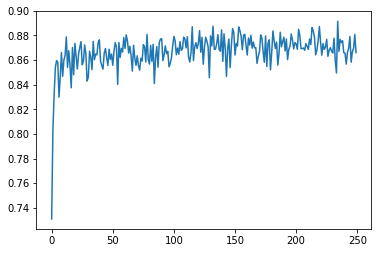

In [15]:
plt.plot(evo.scores)

In [16]:
evo.saveParameters("Parameter {date}.txt".format(date=datetime.now().strftime("%d.%m.%Y %H.%M")))

Parameters saved at Parameter 05.08.2019 21.44.txt!
